# Проект e-learning
## Анализ успеваемости студентов

Для выполнения проекта необходимо:

- Выгрузить и изучить имеющиеся данные.
- Понять как устроены данные и как они связаны между собой.
- Принять решения о трактовке спорных моментов в данных. 
- Исследовать данные на наличие аномалий.
- Выполнить следующие задачи:
    1. Вычислить, сколько студентов успешно сдали только один курс.
    - Выявить самый сложный и самый простой экзамен.
    - По каждому предмету определить средний срок сдачи экзаменов.
    - Выявить самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3).
    - В период с начала 2013 по конец 2014 выявить семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.
    - Построить адаптированные RFM-кластеры студентов, чтобы качественно оценить аудиторию.
- Описать причины решений и расчетов.

In [1]:
#  Импорт необходимых библиотек
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlencode
%matplotlib inline

# Считывание данных

In [2]:
#  Функция для считывания датасета с Яндекс диска
def convert_from_yandex_disk_to_df(path_to_file: str) -> pd.DataFrame:
    '''The input is a link to a document in Yandex disk, the function returns a dataframe'''
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=path_to_file))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return pd.read_csv(download_url)

In [3]:
assessments_url ='https://disk.yandex.ru/d/iSVP1sZ7AdW7TQ'
courses_url = 'https://disk.yandex.ru/d/jmJxR8yhwCXlaw'
studentAssessment_url = 'https://disk.yandex.ru/d/DYd4M5b_8RETsA'
studentRegistration_url = 'https://disk.yandex.ru/d/lqHnH8NOZ458iw'

df_assessments = convert_from_yandex_disk_to_df(assessments_url)
df_courses = convert_from_yandex_disk_to_df(courses_url)
df_studentAssessment = convert_from_yandex_disk_to_df(studentAssessment_url)
df_studentRegistration = convert_from_yandex_disk_to_df(studentRegistration_url)

# Анализ и предобработка данных

## 1. Assessments 
Датафрейм содержит информацию об оценках в тестах. Обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест (экзамен).

- **code_module** — идентификационный код предмета.

- **code_presentation** — семестр (идентификационный код).

- **id_assessment** — тест (идентификационный номер ассессмента).

- **assessment_type** — тип теста. Существуют три типа оценивания: 
    - *TMA* - оценка преподавателя, 
    - *СМА* - компьютерная оценка, 
    - *Exam* - экзамен по курсу, далее по тексту будем называть этот тест **экзамен**.
- **date** — информация об окончательной дате сдачи теста. Рассчитывается как количество дней с момента начала семестра. Дата начала семестра имеет номер 0 (ноль).

- **weight** — вес теста (%) в оценке за курс. Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%.

### Общий анализ

In [4]:
df_assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


Переименуем столбец **date** в более понятный - **deadline**

In [5]:
df_assessments = df_assessments.rename(columns={'date': 'deadline'})

In [6]:
df_assessments.shape

(206, 6)

In [7]:
df_assessments.dtypes

code_module           object
code_presentation     object
id_assessment          int64
assessment_type       object
deadline             float64
weight               float64
dtype: object

In [8]:
df_assessments.nunique()

code_module            7
code_presentation      4
id_assessment        206
assessment_type        3
deadline              74
weight                24
dtype: int64

In [9]:
print('Перечень предметов: ', *df_assessments['code_module'].unique())
print('Перечень семестров: ', *df_assessments['code_presentation'].unique())
print('Перечень видов тестов: ', *df_assessments['assessment_type'].unique())

Перечень предметов:  AAA BBB CCC DDD EEE FFF GGG
Перечень семестров:  2013J 2014J 2013B 2014B
Перечень видов тестов:  TMA Exam CMA


In [10]:
df_assessments[['deadline', 'weight']].describe()

,deadline,weight
count,195.000000,206.000000
mean,145.005128,20.873786
std,76.001119,30.384224
min,12.000000,0.000000
25%,71.000000,0.000000
50%,152.000000,12.500000
75%,222.000000,24.250000
max,261.000000,100.000000


In [11]:
df_assessments.isna().sum()

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
deadline             11
weight                0
dtype: int64

В датафрейме **df_assessments** присутствует **11** пропущенных окончательных дат сдачи теста **deadline**. Проанализируем эти данные.

In [12]:
df_assessments[df_assessments['deadline'].isna()]

,code_module,code_presentation,id_assessment,assessment_type,deadline,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


Пропущенные даты наблюдаются только для экзаменов. 

Посмотрим есть ли в датафрейме **df_assessments** экзамены, для которых установлены ограничения.

In [13]:
df_assessments[(df_assessments['assessment_type']=='Exam') & (df_assessments['deadline'].notna())]

,code_module,code_presentation,id_assessment,assessment_type,deadline,weight
87,DDD,2013B,25340,Exam,240.0,100.0
94,DDD,2013J,25354,Exam,261.0,100.0
101,DDD,2014B,25361,Exam,241.0,100.0
113,EEE,2013J,30713,Exam,235.0,100.0
118,EEE,2014B,30718,Exam,228.0,100.0
123,EEE,2014J,30723,Exam,235.0,100.0
136,FFF,2013B,34872,Exam,222.0,100.0
149,FFF,2013J,34885,Exam,236.0,100.0
162,FFF,2014B,34898,Exam,227.0,100.0
175,FFF,2014J,34911,Exam,241.0,100.0


- Датафрейм **df_assessments** считан корректно. 
- Типы значений столбцов соответствуют действительности, изменять типы не требуется. 
- **4 семестра** (2013J, 2014J, 2013B и 2014B) включают в себя **7 предметов** (AAA, BBB, CCC, DDD, EEE, FFF и GGG), по которым проводится **206 различных тестов**, разбитых на **3 типа** (TMA, CMA и Exam)
- В датафрейме пропущены **11 дат** сдачи экзаменов. Есть три варианта, почему так могло произойти:
    1. Ошибка в данных,
    2. Дедлайны для этих экзаменов не установлены,
    3. Дедлайны для этих экзаменов ограничены другим временем.

Примем решение по дедлайнам этих экзаменов после анализа других датафреймов.

### Анализ количества тестов

Выведем количество разных типов тестов по предметам в разбивке по семестрам

In [14]:
df_tests = df_assessments.groupby(['code_presentation', 'code_module', 'assessment_type'], as_index=False)\
                         .agg({'id_assessment': 'count'})\
                         .sort_values(['code_presentation', 'code_module'])

df_tests.sort_values(['code_module'])\
        .pivot(columns=['code_module', 'assessment_type'], index='code_presentation', values='id_assessment')\
        .fillna(0)

code_module        AAA       BBB            CCC            DDD            EEE  \
assessment_type   Exam  TMA  TMA Exam  CMA  CMA Exam  TMA  TMA Exam  CMA  TMA   
code_presentation                                                               
2013B              0.0  0.0  6.0  1.0  5.0  0.0  0.0  0.0  6.0  1.0  7.0  0.0   
2013J              1.0  5.0  6.0  1.0  5.0  0.0  0.0  0.0  6.0  1.0  0.0  4.0   
2014B              0.0  0.0  6.0  1.0  5.0  4.0  2.0  4.0  6.0  1.0  0.0  4.0   
2014J              1.0  5.0  5.0  1.0  0.0  4.0  2.0  4.0  6.0  1.0  0.0  4.0   

code_module             FFF            GGG            
assessment_type   Exam Exam  TMA  CMA  CMA Exam  TMA  
code_presentation                                     
2013B              0.0  1.0  5.0  7.0  0.0  0.0  0.0  
2013J              1.0  1.0  5.0  7.0  6.0  1.0  3.0  
2014B              1.0  1.0  5.0  7.0  6.0  1.0  3.0  
2014J              1.0  1.0  5.0  7.0  6.0  1.0  3.0

Построим визуализацию количества различных тестов по разным предметам и семестрам

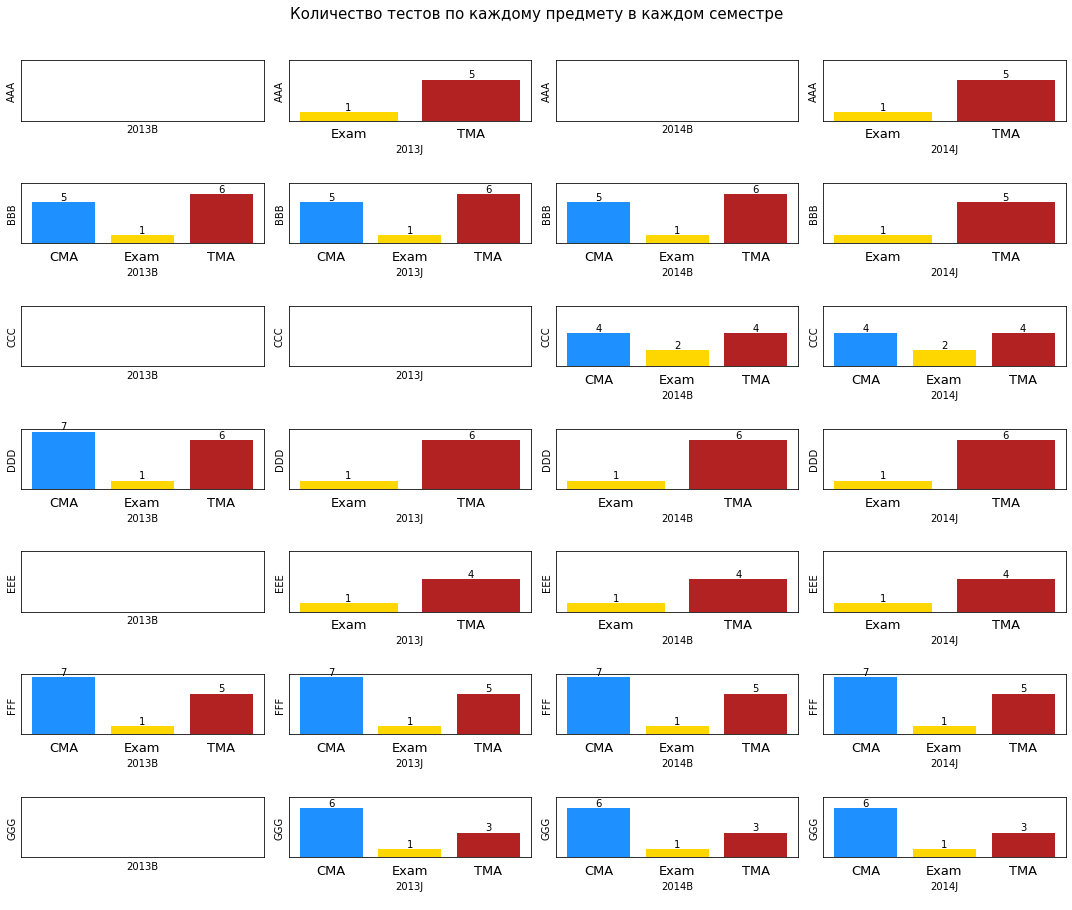

In [15]:
fig, axes = plt.subplots(nrows=7, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(15, 12))
module_range = sorted(df_tests.code_module.unique())
presentation_range = sorted(df_tests.code_presentation.unique())
for i in range(len(module_range)):
    for j in range(len(presentation_range)):
        df = df_tests[(df_tests['code_module'] == module_range[i])
                      & (df_tests['code_presentation'] == presentation_range[j])]
        x = df['assessment_type']
        y = df['id_assessment']
        ax = axes[i, j]
        colors_dict = {'Exam' : 'gold', 
                       'CMA': 'DodgerBlue', 
                       'TMA': 'FireBrick'}
        color_list = [colors_dict[i] for i in df.assessment_type.unique()]
        bars = ax.bar(x, y, color=color_list)
        ax.set_xlabel('{}\n'.format(presentation_range[j]), va='top', fontsize=10)  
        ax.set_ylabel(module_range[i], fontsize=10)   
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=13)
        ax.set_yticks([])        
        for bar in bars:
            value = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='black')
fig.suptitle('Количество тестов по каждому предмету в каждом семестре', fontsize=15, y=1.05)
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

- Не во всех семестрах присутствуют все предметы.
- Не для всех предметов присутствуют все три типа тестов.
- Если по предмету есть тесты **TMA**, то по этому предмету обязательно есть экзамен. 
- В семестрах **2014B** и **2014J** для предмета **CCC** наблюдается по 2 экзамена, выведем их

In [16]:
df_assessments[(df_assessments['code_presentation'].isin(['2014J', '2014B']))
               & (df_assessments['assessment_type'] == 'Exam')
               & (df_assessments['code_module']=='CCC')]

,code_module,code_presentation,id_assessment,assessment_type,deadline,weight
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


По предмету **ССС** в семестрах **2014B** и **2014J** проводится по два заключительных экзамена, у которых отсутствуют дедлайны. Необходимо учесть данный факт в дальнейшем анализе.

### Анализ весов тестов для каждого предмета в разбивке по семестрам

Выведем суммарные веса каждого типа тестов в разбивке по предмету и семестру

In [17]:
df_weight = df_assessments.groupby(['code_presentation', 
                                    'code_module', 
                                    'assessment_type'], as_index=False)\
                          .agg({'weight': 'sum'})\
                          .sort_values(['code_presentation', 'code_module'])

df_weight.sort_values(['code_module'])\
         .pivot(columns=['code_module', 'assessment_type'], index='code_presentation', values='weight')\
         .fillna(0)

code_module          AAA           BBB               CCC                 DDD  \
assessment_type     Exam    TMA    TMA   Exam  CMA   CMA   Exam   TMA    TMA   
code_presentation                                                              
2013B                0.0    0.0   95.0  100.0  5.0   0.0    0.0   0.0   75.0   
2013J              100.0  100.0   95.0  100.0  5.0   0.0    0.0   0.0  100.0   
2014B                0.0    0.0   95.0  100.0  5.0  25.0  200.0  75.0  100.0   
2014J              100.0  100.0  100.0  100.0  0.0  25.0  200.0  75.0  100.0   

code_module                       EEE           FFF              GGG         \
assessment_type     Exam   CMA    TMA   Exam   Exam    TMA  CMA  CMA   Exam   
code_presentation                                                             
2013B              100.0  25.0    0.0    0.0  100.0  100.0  0.0  0.0    0.0   
2013J              100.0   0.0  100.0  100.0  100.0  100.0  0.0  0.0  100.0   
2014B              100.0   0.0  100.0  100.0  100.0  100.0  0.0  0.0  100.0   
2014J              100.0   0.0  100.0  100.0  100.0  100.0  0.0  0.0  100.0   

code_module             
assessment_type    TMA  
code_presentation       
2013B              0.0  
2013J              0.0  
2014B              0.0  
2014J              0.0

Построим визуализацию количества тестов для каждого предмета в разбивке по типу теста и семестру

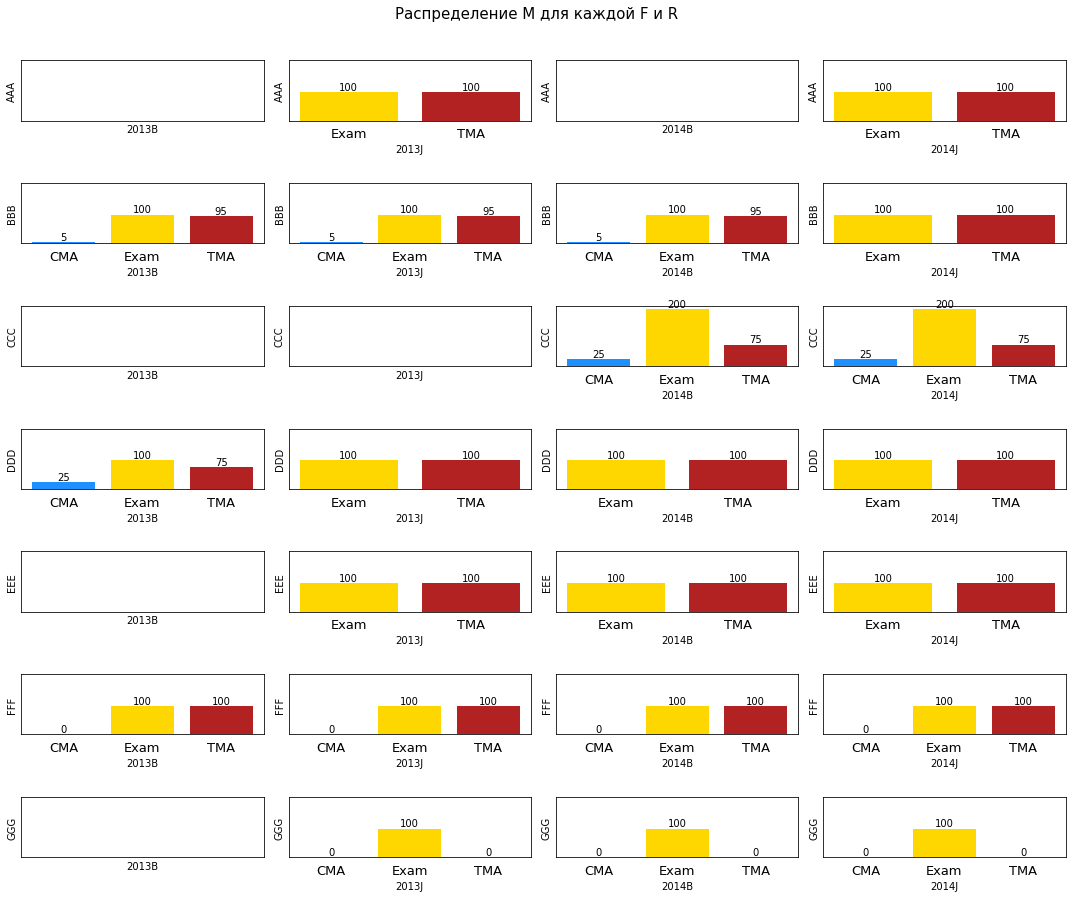

In [18]:
fig, axes = plt.subplots(nrows=7, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(15, 12))
module_range = sorted(df_weight.code_module.unique())
presentation_range = sorted(df_weight.code_presentation.unique())
for i in range(len(module_range)): #r
    for j in range(len(presentation_range)): #f
        df = df_weight[(df_weight['code_module'] == module_range[i]) 
                     & (df_weight['code_presentation'] == presentation_range[j])]
        x = df['assessment_type']
        y = df['weight']
        ax = axes[i, j]
        colors_dict = {'Exam' : 'gold', 'CMA': 'DodgerBlue', 'TMA': 'FireBrick'}
        color_list = [colors_dict[i] for i in df.assessment_type.unique()]
        bars = ax.bar(x, y, color=color_list)
        ax.set_xlabel('{}\n'.format(presentation_range[j]), va='top', fontsize=10)  
        ax.set_ylabel(module_range[i], fontsize=10)   
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=13)
        ax.set_yticks([])        
        for bar in bars:
            value = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='black')
fig.suptitle('Распределение M для каждой F и R', fontsize=15, y=1.05)
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

- Вес экзамена составляет **100%**
- В семестрах **2014B** и **2014J** для предмета **CCC** наблюдается вес экзаменов **200%** (т.к. в данных семестрах **2** экзамена по этому предмету)
- В датафрейме присутствуют тесты, вес которых составляет **0**%
- Для каждого предмета в разбивке по семестрам сумма весов тестов **CMA** и **TMA** равна **100%** (если в семестре присутствует хотя бы один из тестов, вес которого больше **0%**)

### Анализ окончательных дат сдачи тестов для каждого предмета в разбивке по семестрам

Сгруппируем датафрейм **df_assessments** по типу теста, посчитаем минимальное и максимальное значения количества дней для сдачи теста, а затем вычислим размах.

In [19]:
df_assessments_range = df_assessments.groupby('assessment_type')\
                                     .agg({'deadline': (np.min, np.median, np.max)})\
                                     .rename(columns={'amin': 'deadline_min', 
                                                     'median': 'deadline_median', 
                                                     'amax': 'deadline_max'})\
                                     .droplevel(0, axis=1)

df_assessments_range['deadline_range'] = df_assessments_range['deadline_max'] - df_assessments_range['deadline_min']
df_assessments_range

,deadline_min,deadline_median,deadline_max,deadline_range
assessment_type,,,,
CMA,18.0,222.0,241.0,223.0
Exam,222.0,235.0,261.0,39.0
TMA,12.0,110.5,215.0,203.0


Посмотрим на распределение дедлайнов для каждого типа тестов

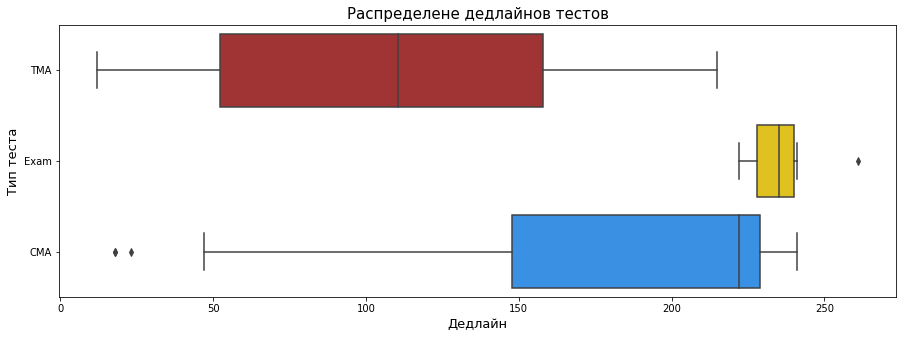

In [20]:
plt.figure(figsize=(15, 5))
ax = sns.boxplot(data=df_assessments, 
                 x='deadline', 
                 y='assessment_type', 
                 palette=['FireBrick', 'gold', 'DodgerBlue'])
ax.set_xlabel('Дедлайн', fontsize=13)
ax.set_ylabel('Тип теста', fontsize=13)
plt.title("Распределене дедлайнов тестов", fontsize=15)
plt.show()

- Медианное количество дней для сдачи теста **CMA** составляет **222** дня с размахом **223** дня.
- Медианное количество дней для сдачи экзамена составляет **235** дней с размахом **39** дней.
- Медианное количество дней для сдачи теста **TMA** составляет **110.5** дней с размахом **203** дня.
- Для тестов **CMA** и **TMA** наблюдается большой размах количества дней для сдачи теста.

## 2. Courses 

Датафрейм содержит список предметов по семестрам
- **code_module** — предмет (идентификационный код).

- **code_presentation** — семестр (идентификационный код).

- **module_presentation_length** — продолжительность семестра в днях.

### Общий анализ

In [21]:
df_courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [22]:
df_courses.shape

(22, 3)

In [23]:
df_courses.nunique()

code_module                   7
code_presentation             4
module_presentation_length    7
dtype: int64

In [24]:
df_courses.dtypes

code_module                   object
code_presentation             object
module_presentation_length     int64
dtype: object

In [25]:
df_courses.isna().sum()

code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64

In [26]:
df_courses.describe()

,module_presentation_length
count,22.000000
mean,255.545455
std,13.654677
min,234.000000
25%,241.000000
50%,261.500000
75%,268.000000
max,269.000000


Посмотрим на распределение продолжительности семестров относительно предметов

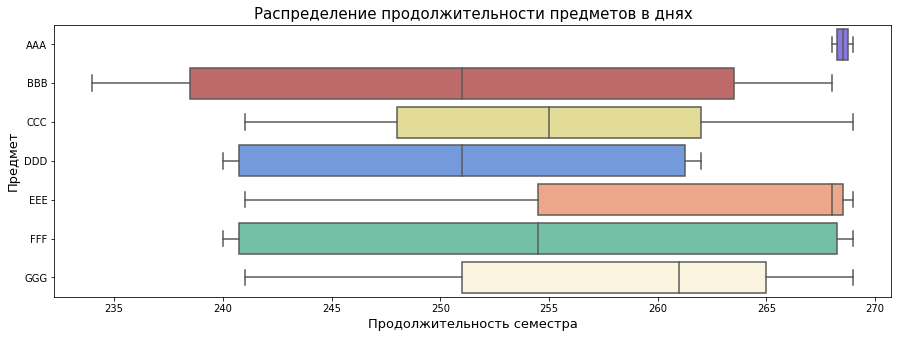

In [27]:
plt.figure(figsize=(15, 5))
ax = sns.boxplot(data=df_courses, 
                 x='module_presentation_length', 
                 y='code_module', 
                 palette=['MediumSlateBlue', 'IndianRed', 'Khaki', 'CornflowerBlue', 
                          'LightSalmon', 'MediumAquamarine', 'Cornsilk'])
ax.set_xlabel('Продолжительность семестра', fontsize=13)
ax.set_ylabel('Предмет', fontsize=13)
plt.title("Распределение продолжительности предметов в днях", fontsize=15)
plt.show()

- Датафрейм **df_courses** считан корректно.
- Типы значений столбцов соответствуют действительности, изменять типы не требуется. 
- Пропущенных значений нет.
- Cеместры длятся в среднем **262** дня (больше, чем полгода).

## 3. Student Assessment

Датафрейм содержит результаты тестов студентов. Если учащийся не сдаёт тест на оценку, результат не записывается в таблицу.

- **id_assessment** — тест (идентификационный номер).

- **id_student** — идентификационный номер студента.

- **date_submitted** — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.

- **is_banked** — факт перезачета теста с прошлого семестра (иногда курсы перезачитывают студентам, вернувшимся из академического отпуска).

- **score** — оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста.

### Общий анализ

In [28]:
df_studentAssessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [29]:
df_studentAssessment.shape

(173912, 5)

In [30]:
df_studentAssessment.nunique()

id_assessment       188
id_student        23369
date_submitted      312
is_banked             2
score               101
dtype: int64

In [31]:
df_studentAssessment.dtypes

id_assessment       int64
id_student          int64
date_submitted      int64
is_banked           int64
score             float64
dtype: object

In [32]:
df_studentAssessment.isna().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

- Датафрейм **df_studentAssessment** считан корректно.
- Типы значений столбцов соответствуют действительности, изменять типы не требуется.
- Количество студентов, которые пытались сдать тест (не факт, что сдали) составляет **23369** человек.
- **173** пропущенные оценки означают, что студенты **173** раза (0.7 %) не сдавали тест на оценку (по условию задачи).
- Студенты сдают **188** тестов из **206** возможных.

## Анализ оценок студентов

In [33]:
df_studentAssessment['score'].describe()

count    173739.000000
mean         75.799573
std          18.798107
min           0.000000
25%          65.000000
50%          80.000000
75%          90.000000
max         100.000000
Name: score, dtype: float64

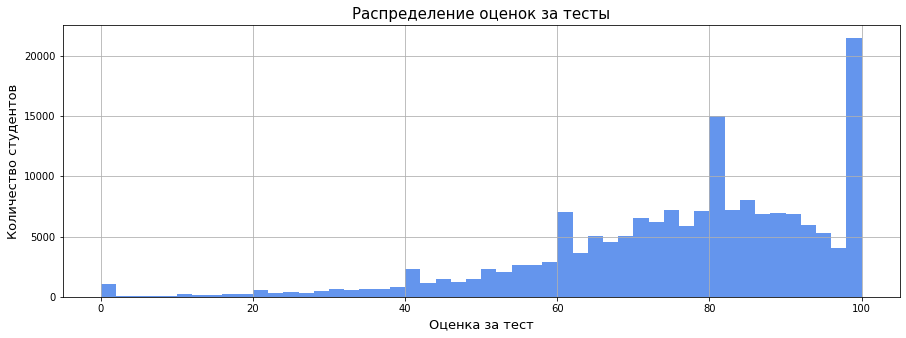

In [34]:
plt.figure(figsize=(15, 5))
ax = df_studentAssessment['score'].hist(color='CornflowerBlue', bins=50)
ax.set_xlabel('Оценка за тест', fontsize=13)
ax.set_ylabel('Количество студентов', fontsize=13)
plt.title("Распределение оценок за тесты", fontsize=15)
plt.show()

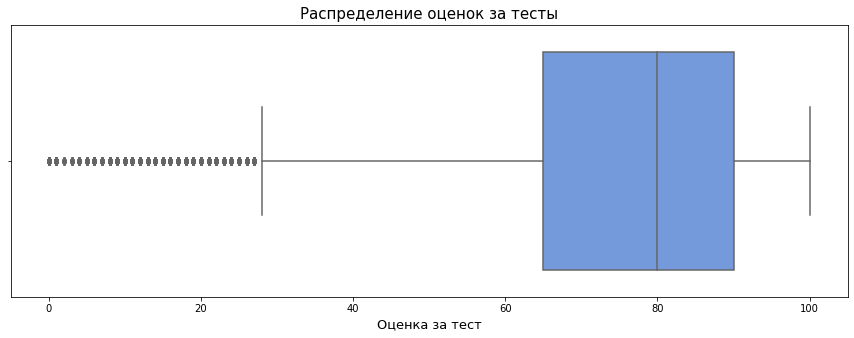

In [35]:
plt.figure(figsize=(15, 5))
ax = sns.boxplot(data=df_studentAssessment, x='score', color='CornflowerBlue')
plt.title("Распределение оценок за тесты", fontsize=15)
ax.set_xlabel('Оценка за тест', fontsize=13)
plt.show()

- Из распределения оценок за тесты видно, что большинство студентов успешно сдают тесты на **65 - 90%**
- Медианная оценка за тесты составляет **75.8**.


### Анализ удачных и неудачных попыток сдать тест

Количество удачных попыток сдать тест

In [36]:
df_studentAssessment.query('score > 40').shape[0]

164195

Количество неудачных попыток сдать тест

In [37]:
df_studentAssessment.query('score <= 40').shape[0]

9544

### Анализ несданных тестов

Посчитаем количество студентов, которые хотя бы раз не сдавали тест на оценку

In [38]:
len(df_studentAssessment[df_studentAssessment.score.isna()].id_student.unique())

160

Посмотрим есть ли студенты, у которых не стоит оценка за тест при перезачёте

In [39]:
df_studentAssessment[df_studentAssessment.score.isna()].query('is_banked == 1')\
                                         .groupby(['id_student', 'is_banked'])\
                                         .agg(count_tests_without_mark=('id_assessment', np.size))\
                                         .reset_index()     

,id_student,is_banked,count_tests_without_mark
0,501208,1,1


Получается, что студент (id 501208) не сдал тест на проверку и ушёл в академический отпуск. Когда он вернулся из академического отпуска, ему перезачли этот результат, т.е. не поставили оценку.  

Посчитаем количество студентов в разбивке по количеству несданных тестов на оценку

In [40]:
df_studentAssessment[df_studentAssessment.score.isna()].groupby('id_student', as_index=False)\
                                                       .id_assessment.count()\
                                                       .groupby('id_assessment', as_index=False)\
                                                       .id_student.count()\
                                                       .rename(columns={'id_assessment': 'count_tests_without_mark', 'id_student': 'students_count'})

,count_tests_without_mark,students_count
0,1,149
1,2,9
2,3,2


- Всего **160** студентов (0.7%) хотя бы один раз не сдали тест на оценку.
- **1** студент (id 501208) не сдал тест до аккадемического отпуска и этот результат был перезачтён.
- **149** студентов не сдавали тест на оценку **1** раз.
- **9** студентов не сдавали тест на оценку **2** раза.
- **2** студента не сдавали тест на оценку **3** раза. 

### Анализ количества перезачётов

Посчитаем количество перезачётов

In [41]:
df_studentAssessment[df_studentAssessment['is_banked']==1].shape[0]

1909

Количество неудачных перезачётов

In [42]:
df_studentAssessment[(df_studentAssessment['is_banked']==1)
                    & (df_studentAssessment['score']<=40)].shape[0]

88

За **4** семестра было **1909** перезачётов, **88** из которых неудачны (4.6%), т.е. студенты до академического отпуска сдали тесты менее, чем на **40** баллов и этот результат им был перезачтён

### Анализ дат сдачи теста

In [43]:
df_studentAssessment['date_submitted'].describe()

count    173912.000000
mean        116.032942
std          71.484148
min         -11.000000
25%          51.000000
50%         116.000000
75%         173.000000
max         608.000000
Name: date_submitted, dtype: float64

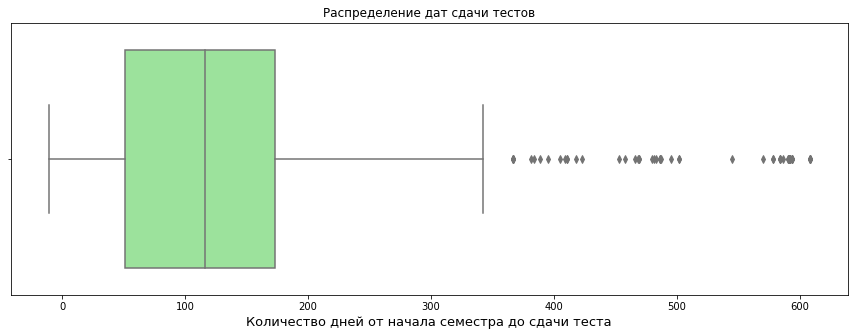

In [44]:
plt.figure(figsize=(15, 5))
ax = sns.boxplot(data=df_studentAssessment, x='date_submitted', color='LightGreen')
plt.title("Распределение дат сдачи тестов")
ax.set_xlabel('Количество дней от начала семестра до сдачи теста', fontsize=13)
plt.show()

В датах сдачи теста наблюдаются отрицателные значения, взглянем на них

In [45]:
df_studentAssessment.query('date_submitted < 0')\
                    ['date_submitted'].unique()

array([ -1,  -4,  -5,  -3,  -6,  -2,  -9, -11,  -7, -10,  -8])

Посмотрим на дни сдачи тестов студентами на перезачётах

In [46]:
df_studentAssessment.query('is_banked == 1')\
                    .date_submitted.unique()

array([-1])

Получается, что студентам, которым ставится перезачёт, устанавливается дата сдачи **-1**

Посмотрим на количество отрицательных дат сдачи тестов, не включая дату **-1**

In [47]:
df_studentAssessment.query('date_submitted < -1').sort_values('date_submitted').shape[0]

130

**130** раз студенты сдавали тесты до начала семестра, скорее всего это тоже перезачёты.

Посмотрим на данные, где дата сдачи теста превышает максимальное из df_assessments (**269** день)

In [48]:
df_studentAssessment.query('date_submitted > 269').shape[0]

73

- В датафрейме присутствует **2057** строк с отрицательными значениями в столбце **date_submitted**.
- Дата сдачи перезачтённого теста проставлена, как **-1**
- Присутствует **130** случаев (0.1%), когда студенты сдавали тест до начала семестра (возможно это также перезачёты)
- **73** раза студенты точно сдали тест позднее дедлайна
- Количество удачных попыток сдать тест составляет **164195** (94.4%)
- Количество неудачных попыток сдать тест составляет **9544** (5.5%)

### 4. Student Registration

Датафрейм содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре.

- **code_module** — предмет (идентификационный код).

- **code_presentation** — семестр (идентификационный код)

- **id_student** — идентификационный номер студента.

- **date_registration** — дата регистрации студента. Это количество дней от начала семестра (например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала).

- **date_unregistration** — дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым.

## Общий анализ

In [49]:
df_studentRegistration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [50]:
df_studentRegistration.shape

(32593, 5)

In [51]:
df_studentRegistration.nunique()

code_module                7
code_presentation          4
id_student             28785
date_registration        332
date_unregistration      416
dtype: int64

In [52]:
df_studentRegistration.dtypes

code_module             object
code_presentation       object
id_student               int64
date_registration      float64
date_unregistration    float64
dtype: object

In [53]:
df_studentRegistration.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

In [54]:
df_studentRegistration[['date_registration', 'date_unregistration']].describe()

,date_registration,date_unregistration
count,32548.000000,10072.000000
mean,-69.411300,49.757645
std,49.260522,82.460890
min,-322.000000,-365.000000
25%,-100.000000,-2.000000
50%,-57.000000,27.000000
75%,-29.000000,109.000000
max,167.000000,444.000000


В датафрейме **df_studentRegistration** обнаружено **45** пропущенных дат регистрации. Предположим, что это ошибка в данных.

Посчитаем среднее количество дней от даты регистрации до начала семестра

In [55]:
Registration_mean = round(df_studentRegistration.date_registration.median())

Заполним отсутствующие значения столбца **date_registration**, где дата отмены регистрации отсутствует, значением **Registration_mean**. Выведем оставшееся количество пропущенных дат регистрации.

In [56]:
df_studentRegistration.loc[(df_studentRegistration.date_registration.isna()) 
                           & (df_studentRegistration.date_unregistration.isna()), 'date_registration'] = Registration_mean
df_studentRegistration[df_studentRegistration.date_registration.isna()].shape[0]

39

Посчитаем среднее количество дней от даты регистрации до даты отмены регистрации 

In [57]:
registration = df_studentRegistration.date_registration
unregistration = df_studentRegistration.date_unregistration
between_registration_unregistration = round((unregistration - registration).median())

Заполним оставшиеся отсутствующие значения дат регистраций (т.е. строки, где значения дат отмен регистраций установлено), значением **between_registration_unregistration**

In [58]:
df_studentRegistration['date_registration'] = df_studentRegistration['date_registration'].fillna(df_studentRegistration['date_unregistration'] - between_registration_unregistration)

In [59]:
df_studentRegistration.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration          0
date_unregistration    22521
dtype: int64

## Анализ регистраций и отмен регистраций

### Анализ регистраций

Посмотрим на распределение дней регистрации на предмет

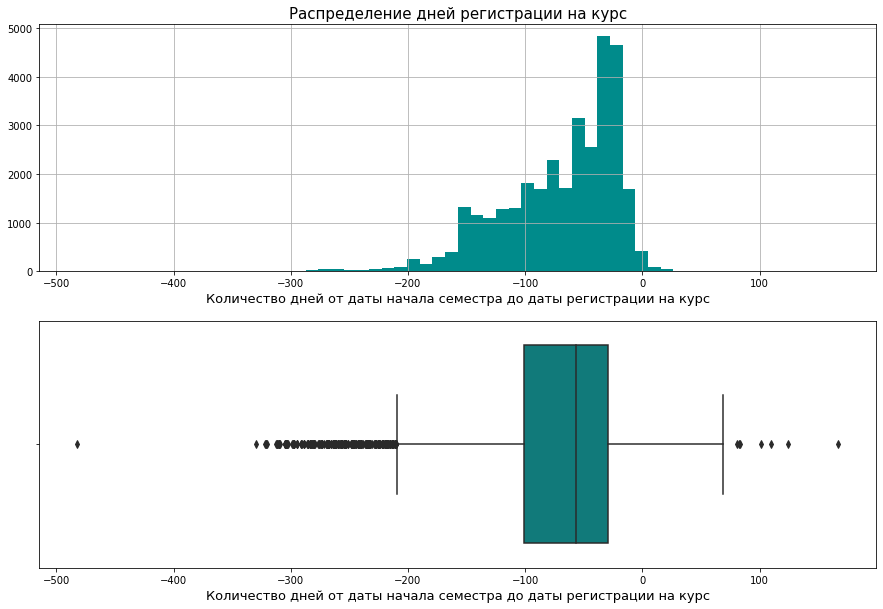

In [60]:
registration_color = 'DarkCyan'

fig, axs = plt.subplots(2, 1, figsize=(15, 10))

df_studentRegistration.date_registration.hist(bins=60, color=registration_color, ax=axs[0])
axs[0].set_title('Распределение дней регистрации на курс', fontsize=15)
axs[0].set_xlabel('Количество дней от даты начала семестра до даты регистрации на курс', fontsize=13)

sns.boxplot(data=df_studentRegistration, x='date_registration', color=registration_color, ax=axs[1])
axs[1].set_xlabel('Количество дней от даты начала семестра до даты регистрации на курс', fontsize=13)

plt.show()

Исходя из распредления дней регистрации на курс можно сделать вывод: чем ближе дата начала семестра, тем больше людей регистрируется на него. Все студенты регистрируются на предметы не позднее, чем длительность семестров.

### Анализ отмен регистраций
Посмотрим на распределение дней отмен регистрации на предмет

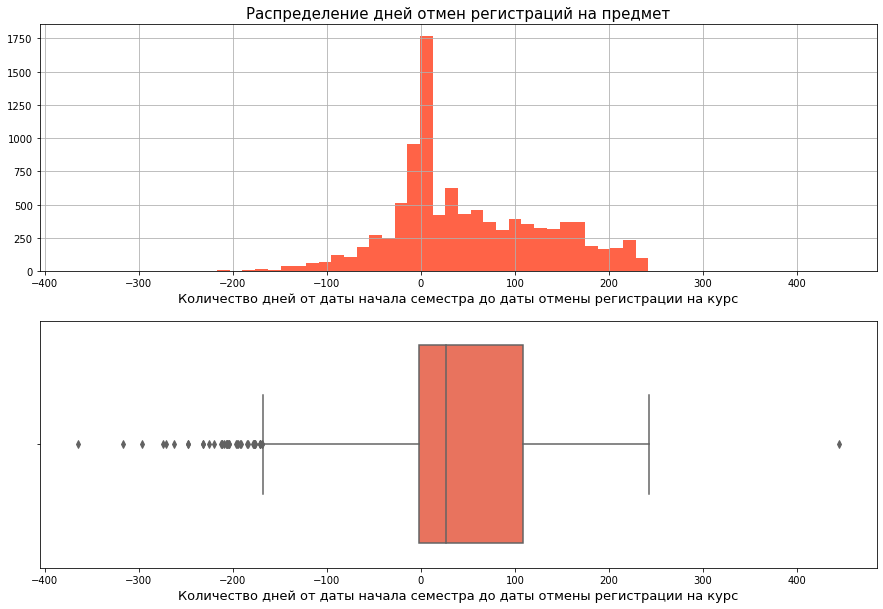

In [61]:
unregistration_color = 'Tomato'

fig, axs = plt.subplots(2, 1, figsize=(15, 10))

df_studentRegistration.date_unregistration.hist(bins=60, color=unregistration_color, ax=axs[0])
axs[0].set_title('Распределение дней отмен регистраций на предмет', fontsize=15)
axs[0].set_xlabel('Количество дней от даты начала семестра до даты отмены регистрации на курс', fontsize=13)

sns.boxplot(data=df_studentRegistration, x='date_unregistration', color=unregistration_color, ax=axs[1])
axs[1].set_xlabel('Количество дней от даты начала семестра до даты отмены регистрации на курс', fontsize=13)

plt.show()

Исходя из распределения дней отмены регистраций на предмет можно сделать вывод, что максимальное количество студентов отменяют регистрацию в начале обучения. 

Выведем студента, который отменил регистрацию позднее, чем максимальная продолжительность семестра (**269** дней)

In [62]:
df_studentRegistration.query('date_unregistration > 269')

,code_module,code_presentation,id_student,date_registration,date_unregistration
25249,FFF,2013J,586851,-22.0,444.0


Данный студент отменил регистрацию на предмет позднее продолжительности семестра. Возможно, он уходил в академический отпуск, и после возвращения отменил регистрацию.

### Анализ регистраций и их отмен студентами

Посчитаем для каждого студента количество регистраций и количество отмен регистраций, затем вычтем из количества регистраций количество отмен регистраций. 

In [63]:
Registration_unregistration =  df_studentRegistration.groupby('id_student', as_index=False)\
                                                     .agg({'date_registration': lambda x: len(pd.Series(x).dropna()),
                                                           'date_unregistration': lambda x: len(pd.Series(x).dropna())})\
                                                     .sort_values('date_registration')
                            
Registration_unregistration['result_registration'] = Registration_unregistration['date_registration'] - Registration_unregistration['date_unregistration']
Registration_unregistration.head()

,id_student,date_registration,date_unregistration,result_registration
0,3733,1.0,1.0,0.0
18738,623548,1.0,1.0,0.0
18737,623542,1.0,0.0,1.0
18736,623541,1.0,0.0,1.0
18735,623537,1.0,0.0,1.0


Сгруппируем датафрейм по результирующему количеству регистраций и посчитаем количество студентов. Таким образом узнаем общее количество студентов, которые продолжают учиться, либо завершили обучение.

In [64]:
Res_regestration = Registration_unregistration.groupby('result_registration', as_index=False)\
                                              .agg(studens_count=('id_student', np.size))
Res_regestration

,result_registration,studens_count
0,0.0,7595
1,1.0,19868
2,2.0,1313
3,3.0,9


Посчитаем количество студентов, которые продолжают учиться, либо завершили обучение.

In [65]:
Res_regestration.query('result_registration != 0').studens_count.sum()

21190

- В датафрейме **df_studentRegistration** пропущены **22521** дат отмены регистрации
- Полностью отменили обучение **7595** студентов (26.39%)
- Количество студентов, которые либо завершили обучение, либо учатся до сих пор (т.е. не отменили регистрацию) составляет **21190** (73.61%) из них:
 - Обучаются/закончили обучение на одном предмете - **19868** студентов (69.02%)
 - На двух предметах - **1313** студентов (4.56%)
 - На трёх предметах - **9** студентов (0.03%)

### Количество регистраций и отмен регистраций по семестрам и предметам

Посмотрим на количество регистраций в каждом семестре по каждому предмету

In [66]:
df_studentRegistration.groupby(['code_presentation', 'code_module'])\
                      .date_registration.count()\
                      .unstack()\
                      .fillna(0)

code_module,AAA,BBB,CCC,DDD,EEE,FFF,GGG
code_presentation,,,,,,,
2013B,0.0,1767.0,0.0,1303.0,0.0,1614.0,0.0
2013J,383.0,2237.0,0.0,1938.0,1052.0,2283.0,952.0
2014B,0.0,1613.0,1936.0,1228.0,694.0,1500.0,833.0
2014J,365.0,2292.0,2498.0,1803.0,1188.0,2365.0,749.0


Посмотрим на количество регистраций в каждом семестре по каждому предмету

In [67]:
df_studentRegistration.groupby(['code_presentation', 'code_module'])\
                      .date_unregistration.count()\
                      .unstack()\
                      .fillna(0)

code_module,AAA,BBB,CCC,DDD,EEE,FFF,GGG
code_presentation,,,,,,,
2013B,0.0,505.0,0.0,431.0,0.0,411.0,0.0
2013J,60.0,647.0,0.0,684.0,243.0,677.0,65.0
2014B,0.0,489.0,898.0,489.0,173.0,461.0,100.0
2014J,66.0,736.0,1049.0,631.0,302.0,831.0,124.0


Студенты регистрируются и отменяют регистрации на все возможные предметы в каждом семестре.

# ВЫВОДЫ ПО АНАЛИЗУ:

1. **4 семестра** (2013J, 2014J, 2013B и 2014B) включают в себя **7 предметов** (AAA, BBB, CCC, DDD, EEE, FFF и GGG), по которым проводится **206 различных тестов**, разбитых на **3 типа** (TMA, Exam и CMA)
- Исходя из проведённого анализа под термином **курс** будем понимать один предмет в одном семестре, который состоит из различного количества тестов **CMA**, **TMA** и заключительного экзамена **Exam**.
- Курсы длятся в среднем **262** дня (**больше, чем полгода**)
- Для каждого курса сумма весов тестов **CMA** и **TMA** равна **100%**. Вес экзамена составляет **100%**
- Курсы **2014B_ССС** и **2014J_ССС** включают в себя по 2 экзамена, вес каждого из них составляет **100**%
- Если для конкретного теста указан вес (не равный 0), будем считать его обязательным
- Большой размах количества дней для сдачи тестов **CMA** и **TMA** обусловлен тем, что тесты сдаются на протяжении всего курса.
- Количество студентов, которые зарегистрировались на прохождение курса составляет **28785** человек
- 7595 студентов (26.39%) полностью отменили обучение 
- Количество студентов, которые либо завершили обучение, либо учатся до сих пор (т.е. не отменили регистрацию как минимум на один курс) составляет **21190** человек (73.61%) из них:
 - Обучаются/закончили обучение на одном курсе - **19868** студентов (69.02%)
 - На двух курсах - **1313** студентов (4.56%)
 - На трёх курсах - **9** студентов (0.03%)
- Медианная оценка за тесты составляет **75.8**%.
- Количество удачных попыток сдать тест составляет **164195** (94.4%) 
- Количество неудачных попыток сдать тест составляет **9544** (5.5%)
- Студенты не сдавали тест на оценку **173** раза (0.1%)
- В датафрейме **df_assessments** пропущены **11** дедлайнов сдачи экзаменов, заполним их продолжительностью семестра, в котором присутствует данный экзамен.

# Предобработка датафреймов

Посмотрим на типы тестов в датафрейме **df_studentAssessment**, у которых отсутствуют оценки. 

Объединим датафреймы **df_studentAssessment** и **df_assessments** и выведем уникальные значения столбца **assessment_type**

In [68]:
df_studentAssessment[df_studentAssessment.score.isna()].merge(df_assessments, on='id_assessment', how='left')\
                                                       .assessment_type.unique()

array(['TMA'], dtype=object)

Тип всех несданных тестов - **TMA**

Добавим в датафреймы **Assessments**, **Courses**, **studentRegistration** колонку с наименованием курса **code_course**, которая будет иметь вид:

**code presentation_code module**

In [69]:
df_assessments['code_course'] = df_assessments['code_presentation'] + '_' + df_assessments['code_module']
df_courses['code_course'] = df_courses['code_presentation'] + '_' + df_courses['code_module']
df_studentRegistration['code_course'] = df_studentRegistration['code_presentation'] + '_' + df_studentRegistration['code_module']

В датафрейме **df_assessments** пропущенные дедлайны для экзаменов за курс заполним продолжительностью семестра, в котором присутствует данный экзамен. 

In [70]:
df_merge = df_assessments.merge(df_courses, on=['code_module', 'code_presentation'], how='left')
df_merge['deadline'] = df_merge['deadline'].fillna(df_merge['module_presentation_length'])
df_assessments['deadline'] = df_merge['deadline']

Проверим остались ли пропущенные дедлайны тестов

In [71]:
df_assessments['deadline'].isna().sum()

0

В датафрейме **df_studentAssessment** **130** дат сдачи тестов меньше **-1**, предположим, что это ошибка в данных и данные оценки устанавливаются перезачётом. Установим для этих строк дату сдачи теста **date_submitted** - **-1** и в столбец **is_banked** - запишем **1**

In [72]:
# Для самопроверки смотрим количество дат меньше -1, количество перезачётов и количество строк в датафрейме
print('Количество дат меньше 0:', df_studentAssessment.query('date_submitted <= -1').shape[0])
print('Количество перезачётов:', df_studentAssessment.query('is_banked == 1').shape[0])
print('Количество строк в датафрейме:', df_studentAssessment.shape[0])

Количество дат меньше 0: 2057
Количество перезачётов: 1909
Количество строк в датафрейме: 173912


In [73]:
df_studentAssessment.loc[df_studentAssessment['date_submitted'] <= -1, 'is_banked'] = 1
df_studentAssessment.loc[df_studentAssessment['is_banked'] == 1, 'date_submitted'] = -1

In [74]:
print('Количество дат меньше 0:', df_studentAssessment.query('date_submitted == -1').shape[0])
print('Количество перезачётов:', df_studentAssessment.query('is_banked == 1').shape[0])
print('Количество строк в датафрейме:', df_studentAssessment.shape[0])

Количество дат меньше 0: 2057
Количество перезачётов: 2057
Количество строк в датафрейме: 173912


Из анализа датафрейма **df_studentAssessment** мы выяснили, что студенты сдают **188** тестов из **206** возможных, посмотрим какие тесты студенты не сдают. Для этого выведем датафрейм **df_assessments**, в который не будут входить тесты из датафрейма **df_studentAssessment**.

In [75]:
students_tests = df_studentAssessment['id_assessment'].unique()
df_assessments[~ df_assessments['id_assessment'].isin(students_tests)]

,code_module,code_presentation,id_assessment,assessment_type,deadline,weight,code_course
5,AAA,2013J,1757,Exam,268.0,100.0,2013J_AAA
11,AAA,2014J,1763,Exam,269.0,100.0,2014J_AAA
23,BBB,2013B,14990,Exam,240.0,100.0,2013B_BBB
35,BBB,2013J,15002,Exam,268.0,100.0,2013J_BBB
47,BBB,2014B,15014,Exam,234.0,100.0,2014B_BBB
53,BBB,2014J,15025,Exam,262.0,100.0,2014J_BBB
63,CCC,2014B,40087,Exam,241.0,100.0,2014B_CCC
73,CCC,2014J,40088,Exam,269.0,100.0,2014J_CCC
113,EEE,2013J,30713,Exam,235.0,100.0,2013J_EEE
118,EEE,2014B,30718,Exam,228.0,100.0,2014B_EEE


Студенты не сдают экзамены по большому количеству курсов. Выведем список курсов для предоставления отчёта.

In [76]:
print(*df_assessments[~ df_assessments['id_assessment'].isin(students_tests)].code_course.unique(), sep=', ')

2013J_AAA, 2014J_AAA, 2013B_BBB, 2013J_BBB, 2014B_BBB, 2014J_BBB, 2014B_CCC, 2014J_CCC, 2013J_EEE, 2014B_EEE, 2014J_EEE, 2013B_FFF, 2013J_FFF, 2014B_FFF, 2014J_FFF, 2013J_GGG, 2014B_GGG, 2014J_GGG


Посмотрим на типы тестов, по которым стоит перезачёт

In [77]:
df_studentAssessment.merge(df_assessments, on='id_assessment', how='left')\
                    .query('is_banked == 1')\
                    .groupby('assessment_type', as_index=False)\
                    .id_student.count()

,assessment_type,id_student
0,CMA,641
1,TMA,1416


В датафреме **df_assessments** не встречается перезачёт по экзамену за курс

Посмотрим какой именно тест не сдал студент (id 501208) на проверку

In [78]:
df_studentAssessment.query('score.isna() & id_student == 501208')\
                    .merge(df_assessments, on='id_assessment', how='left')
                   

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,deadline,weight,code_course
0,14997,501208,-1,1,NaN,BBB,2013J,TMA,47.0,18.0,2013J_BBB


Студент (id 501208) не сдал на проверку тест преподавателю по курсу **2013J_BBB**

# Ответы на поставленные вопросы

## 1. Сколько студентов успешно сдали только один курс?

Для начала определим, что такое **"успешная сдача"**. Под ней будем понимать выполнение следующих условий:
1. оценка по экзамену не менее 40 (score >= 40)
2. количество дней между **сдачей экзамена** и **дедлайном** не менее **0**. 

Создадим датафрейм **Students_assessments_data**, в который запишем данные объединённых датафреймов **df_studentAssessment** и **df_assessments**.

In [79]:
Students_assessments_data = df_studentAssessment.merge(df_assessments, on='id_assessment', how='left')

Добавим в получившийся датафрейм столбец **days_until_deadline**, в который запишем оставшееся количество дней от сдачи студентом экзамена до дедлайна.

In [80]:
Students_assessments_data['days_until_deadline'] = Students_assessments_data.deadline - Students_assessments_data.date_submitted
Students_assessments_data.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,deadline,weight,code_course,days_until_deadline
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0,2013J_AAA,1.0
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0,2013J_AAA,-3.0
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0,2013J_AAA,2.0
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0,2013J_AAA,-7.0
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0,2013J_AAA,0.0


Добавим колонку **is_success**, в которую запишем **1**, если сдача теста удачная (score >= 40 и days_until_deadline >= 0), **0** - неудачная

In [81]:
Students_assessments_data['is_success'] = np.where((Students_assessments_data['score'] >= 40)\
                                                   & (Students_assessments_data['days_until_deadline'] >= 0), 
                                                   1, 0)

Изменим порядок столбцов для удобства дальнейшего анализа.

In [82]:
Students_assessments_data = Students_assessments_data[['id_student', 'id_assessment', 'code_module',
                                                       'code_presentation', 'code_course', 'assessment_type',
                                                       'weight', 'is_banked', 'score', 'date_submitted', 'deadline',
                                                       'days_until_deadline', 'is_success']]
Students_assessments_data.head()

,id_student,id_assessment,code_module,code_presentation,code_course,assessment_type,weight,is_banked,score,date_submitted,deadline,days_until_deadline,is_success
0,11391,1752,AAA,2013J,2013J_AAA,TMA,10.0,0,78.0,18,19.0,1.0,1
1,28400,1752,AAA,2013J,2013J_AAA,TMA,10.0,0,70.0,22,19.0,-3.0,0
2,31604,1752,AAA,2013J,2013J_AAA,TMA,10.0,0,72.0,17,19.0,2.0,1
3,32885,1752,AAA,2013J,2013J_AAA,TMA,10.0,0,69.0,26,19.0,-7.0,0
4,38053,1752,AAA,2013J,2013J_AAA,TMA,10.0,0,79.0,19,19.0,0.0,1


Создадим датафрейм **Success_Exams**, в который запишем удачные сдачи экзаменов из датафрейма **Students_assessments_data**

In [83]:
Success_exams = Students_assessments_data.query('assessment_type == "Exam"\
                                                & is_success == 1')
Success_exams.head()

,id_student,id_assessment,code_module,code_presentation,code_course,assessment_type,weight,is_banked,score,date_submitted,deadline,days_until_deadline,is_success
52924,559706,24290,CCC,2014B,2014B_CCC,Exam,100.0,0,78.0,234,241.0,7.0,1
52925,559770,24290,CCC,2014B,2014B_CCC,Exam,100.0,0,54.0,230,241.0,11.0,1
52926,560114,24290,CCC,2014B,2014B_CCC,Exam,100.0,0,64.0,230,241.0,11.0,1
52927,560311,24290,CCC,2014B,2014B_CCC,Exam,100.0,0,100.0,234,241.0,7.0,1
52928,560494,24290,CCC,2014B,2014B_CCC,Exam,100.0,0,92.0,230,241.0,11.0,1


Из анализа датафрейма **df_assessments** мы выяснили, что для сдачи курсов **2014B_CCC** и **2014J_CCC** требуется сдать два экзамена, поэтому посчитаем количество сданных экзаменов в разбивке по **id_student** и **code_course**. Выведем студентов с максимальным количеством сданных экзаменов.

In [84]:
Exam_success = Success_exams.groupby(['id_student', 'code_course'])\
                            .id_assessment.count()\
                            .reset_index()\
                            .rename(columns={'id_assessment': 'count_success_exam'})\
                            .sort_values('count_success_exam', ascending=False)
Exam_success.head()

,id_student,code_course,count_success_exam
0,23698,2014J_CCC,1
2919,628008,2014B_DDD,1
2925,628216,2014B_DDD,1
2924,628157,2014B_CCC,1
2923,628114,2014J_CCC,1


Из датафрейма выше видно, что студенты сдавали по каждому курсу максимум 1 заключительный экзамен, следовательно никто из студентов ещё не сдал успешно курсы **2014B_CCC** и **2014J_CCC** (для них требуется сдать два заключительных экзамена). 

Выведем количество студентов, сдавших по одному экзамену за курсы **2014B_CCC** и **2014J_CCC**

In [85]:
Exam_success.query('code_course == "2014J_CCC" | code_course == "2014B_CCC"').groupby('code_course', as_index=False).count_success_exam.sum()

,code_course,count_success_exam
0,2014B_CCC,662
1,2014J_CCC,1018


Удалим из датафрейма **Exam_success** строки, содержащие курсы **2014J_CCC** и **2014B_CCC**

In [86]:
Exam_success.shape[0]

4382

In [87]:
Exam_success = Exam_success.query('code_course != "2014B_CCC" and code_course != "2014J_CCC"')
Exam_success.shape[0]

2702

Теперь посчитаем количество успешно сданных экзаменов для каждого студента

In [88]:
res_exam_success = Exam_success.groupby('id_student')\
                               .count_success_exam.sum()\
                               .reset_index()\
                               .sort_values('count_success_exam', ascending=False)
res_exam_success.head()

,id_student,count_success_exam
1494,593903,2
1652,605118,2
905,540758,2
0,24213,1
1802,621883,1


Посчитаем количество студентов, успешно сдавших только 1 экзамен

In [89]:
res_exam_success.query('count_success_exam == 1').shape[0]

2696

2696 студентов завершили курс, сдав успешно заключительный экзамен.

В качестве дополнительного анализа, посмотрим сколько студентов завершили курс **полностью**, сдав все необходимые тесты. 

Под необходимыми тестами будем понимать тест, вес которого больше **0**.

Для этого используем датафрейм **df_assessments**, оставив в нём тесты, вес которых больше нуля

In [90]:
required_assessments_by_course = df_assessments.query('weight > 0')\
                                               .groupby(['code_course'])\
                                               .agg({'id_assessment': lambda x: sorted(x)})\
                                               .reset_index()\
                                               .rename(columns={'id_assessment': 'assessment_list'})
required_assessments_by_course.head()

,code_course,assessment_list
0,2013B_BBB,"[14984, 14985, 14986, 14987, 14988, 14989, 149..."
1,2013B_DDD,"[25334, 25335, 25336, 25337, 25338, 25339, 253..."
2,2013B_FFF,"[34860, 34861, 34862, 34863, 34864, 34872]"
3,2013J_AAA,"[1752, 1753, 1754, 1755, 1756, 1757]"
4,2013J_BBB,"[14996, 14997, 14998, 14999, 15000, 15001, 150..."


Создадим датафрейм **student_required_assessments**, в который запишем данные из **Students_assessments_data**, где вес теста больше 0 и сдача теста удачная.

In [91]:
student_required_assessments = Students_assessments_data.query('weight > 0 & is_success == 1')

Сгруппируем получившийся датафрейм по **id_student** и **code_course**, в качестве значений будет отсортированный (для облегчения дальнейшего анализа) список, успешно сданных студентом тестов.

In [92]:
student_success_required = student_required_assessments.groupby(['id_student', 'code_course'])\
                                                       .agg({'id_assessment': lambda x: sorted(x)})\
                                                       .reset_index()\
                                                       .rename(columns={'id_assessment': 'success_assessment_list'})
student_success_required.head()

,id_student,code_course,success_assessment_list
0,6516,2014J_AAA,"[1758, 1759, 1760, 1761, 1762]"
1,8462,2013J_DDD,"[25349, 25350]"
2,8462,2014J_DDD,"[25362, 25363, 25364, 25365]"
3,11391,2013J_AAA,"[1752, 1753, 1754, 1755, 1756]"
4,23629,2013B_BBB,[14984]


Добавим к датафрейму **Student_required_assessments** данные из датафрейма **required_assessments_by_course**

In [93]:
student_success_courses = student_success_required.merge(required_assessments_by_course, on='code_course')                      
student_success_courses.head()

,id_student,code_course,success_assessment_list,assessment_list
0,6516,2014J_AAA,"[1758, 1759, 1760, 1761, 1762]","[1758, 1759, 1760, 1761, 1762, 1763]"
1,24734,2014J_AAA,[1762],"[1758, 1759, 1760, 1761, 1762, 1763]"
2,26192,2014J_AAA,"[1758, 1759, 1760, 1761, 1762]","[1758, 1759, 1760, 1761, 1762, 1763]"
3,28061,2014J_AAA,"[1758, 1760, 1761, 1762]","[1758, 1759, 1760, 1761, 1762, 1763]"
4,31600,2014J_AAA,"[1759, 1762]","[1758, 1759, 1760, 1761, 1762, 1763]"


Проверим, есть ли студенты, которые за один курс успешно сдали больше тестов, чем требуется

In [94]:
student_success_courses[student_success_courses['success_assessment_list'].str.len() > student_success_courses['assessment_list'].str.len()].shape[0]

0

Таких студентов нет. 

Тогда оставим только те данные, где список необходимых для курса тестов **assessment_list** такой же, как список тестов, успешно сданных студентом **success_assessment_list**

In [95]:
Student_success_courses = student_success_courses.query('assessment_list == success_assessment_list').drop(['success_assessment_list', 'assessment_list'], axis=1)
Student_success_courses.head()

,id_student,code_course
331,40184,2013J_DDD
332,40419,2013J_DDD
333,40563,2013J_DDD
337,51163,2013J_DDD
339,57818,2013J_DDD


In [96]:
Student_success_courses.shape[0]

1029

Сгруппируем датафрейм **Student_success_courses** по **id_student** и через функцию **count** посчитаем для каждого студента количество успешно пройденных курсов. Выведем количество тех студентов, которые успешно сдали только 1 курс целиком

In [97]:
res_success = Student_success_courses.groupby('id_student')\
                                       .agg({'code_course': 'count'})\
                                       .rename(columns={'code_course': 'course_count'})\
                                        .sort_values('course_count')\
                                        .query('course_count == 1')
res_success.shape[0]

1029

Все необходимые для сдачи курса тесты сдали **1029** студентов. Причём все студенты целиком сдавали максимум **один курс**.

### Ответ: 

Для ответа на поставленный вопрос, мной было принято решение посчитать количество студентов, сдавших все необходимые тесты за курс и отдельно посчитать количество студентов, сдавших хотя бы заключительный экзамен.
* Количество студентов, успешно сдавших 1 курс (т.е. сдавших хотя бы заключительный экзамен) составляет **2626** студентов
* Количество студентов, успешно сдавших 1 курс **целиком** (т.е. сдавший все необходимые тесты) - **1029** студентов
* Количество студентов, сдавших только один экзамен из двух необходимых по курсу **2014B_CCC** - **662** студента
* Количество студентов, сдавших только один экзамен из двух необходимых по курсу **2014J_CCC** - **1018** студентов

## 2. Выявим самый сложный и самый простой экзамен. 

Найдём курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой **завершаемостью**.

Под **завершаемостью экзаменов** будем понимать отношение количества успешных сдач экзаменов к количеству всех попыток сдать экзамены.

Под **завершаемостью курсов** будем понимать отношение количества успешных сдач тестов (**CMA**, **TMA** и **Exam**) к количеству всех попыток сдать тесты (в рамках курса).

Воспользуемся датафреймом **Students_assessments_data**, сгруппируем его по столбцам **code_presentation**, **code_module** с подсчётом количества успешных попыток сдать тест (через **sum**) и количества всех попыток(через **np.size**), назовём их **success_tests** и **total_tests** соответственно.

In [98]:
Course_completion = Students_assessments_data.groupby(['code_course'], as_index=False)\
                                             .agg(success_tests=('is_success', np.sum),
                                                  total_tests=('is_success', np.size))
Course_completion.head()

,code_course,success_tests,total_tests
0,2013B_BBB,4784,11256
1,2013B_DDD,4032,10373
2,2013B_FFF,10683,12195
3,2013J_AAA,1226,1633
4,2013J_BBB,6575,14375


Добавим столбец с завершаемостью **completion**, отсортируем датафрейм по этому столбцу

In [99]:
Course_completion['completion'] = round(100 * Course_completion['success_tests'] / Course_completion['total_tests'], 2)
Course_completion = Course_completion.sort_values('completion')
Course_completion = Course_completion.drop(['success_tests', 'total_tests'], axis=1)

### Самый сложный курс

In [100]:
Course_completion.head(1)

,code_course,completion
10,2014B_CCC,36.39


### Самый простой курс

In [101]:
Course_completion.tail(1)

,code_course,completion
8,2013J_GGG,89.53


Произведём аналогичный перечень преобразований для нахождения самого лёгкого и самого сложного экзаменов

1. Cгруппируем датафрейм **Students_assessments_data** по столбцам **code_presentation**, **code_module**, **assessment_type** и **id_assessment** (*этот столбец необходим, т.к. для курсов 2014B_CCC и 2014J_CCC студент должен сдать два экзамена*) с подсчётом количества успешных попыток сдать экзамен (через **sum**) и количества всех попыток (через **size**), назовём их **success_exams** и **total_exams** соответственно.
2. Добавим столбец **completion**, отсортируем датафрейм 
3. Оставим только необходимые столбцы - **code_course** и **completion**

In [102]:
Exam_completion = Students_assessments_data.query('assessment_type == "Exam"')\
                                           .groupby(['code_course', 'id_assessment'], as_index=False)\
                                           .agg(success_exams=('is_success', np.sum),
                                                total_exams=('is_success', np.size))
Exam_completion['completion'] = round(100 * Exam_completion['success_exams'] / Exam_completion['total_exams'], 2)
Exam_completion = Exam_completion.sort_values('completion')
Exam_completion.drop(['success_exams', 'total_exams', 'id_assessment'], axis=1, inplace=True)

### Самый сложный экзамен

In [103]:
Exam_completion.head(1)

,code_course,completion
0,2013B_DDD,83.22


### Самый простой экзамен

In [104]:
Exam_completion.tail(1)

,code_course,completion
3,2014B_DDD,91.98


### Ответ:

1. Самый сложный курс **2014B_CCC** (Завершаемость - **36.39** %)
2. Самый простой курс **2014J_FFF** (Завершаемость -  **89.53** %)
3. Самый сложный экзамен - **2013B_DDD** (Завершаемость - **83.22** %)
4. Самый простой экзамен - **2014B_DDD**	(Завершаемость - **91.98** %)


## 3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом)

Для решения данной задачи посчитаем средниие сроки сдачи экзаменов с начала семестра

Воспользуемся датафреймом из предыдущего шага **Students_assessments_data**. Посмотрим есть ли в этом датафрейме  студенты, которые несколько раз успешно сдавали один и тот же экзамен. Оставим в датафрейме только успешные экзамены, также исключим перезачёты, т.к. для перезачётов устанавливается время сдачи теста **-1**.

In [105]:
Student_Exams_success = Students_assessments_data.query('is_success == 1 \
                                                        & assessment_type == "Exam"\
                                                        & is_banked == 0')
Student_Exams_success[Student_Exams_success.duplicated(subset=['code_course', 'id_student'])].shape[0]

0

Таких студентов не оказалось.



Посмотрим на значения в столбце **date_submitted**

In [106]:
Student_Exams_success['date_submitted'].describe()

count    4382.000000
mean      238.467595
std         5.606777
min       229.000000
25%       234.000000
50%       241.000000
75%       243.000000
max       259.000000
Name: date_submitted, dtype: float64

Отрицательных значений нет. Сгруппируем датафрейм **Success_exams** по предметам и посчитаем медианное количество дней сдачи экзаменов с момента начала курса.

In [107]:
Student_Exams_success.groupby('code_module', as_index=False)\
               .agg(days_submitted_median=('date_submitted', np.median))

,code_module,days_submitted_median
0,CCC,244
1,DDD,237


### Ответ:

* Средний срок сдачи экзамена по предмету **CCC** в среднем составляет **244** дня с момента начала семестра 
* Средний срок сдачи экзамена по предмету **DDD** - **237** дней с момента начала семестра 
* Студенты не сдавали экзамены по другим предметам, поэтому расчёт среднего срока сдачи экзамена невозможен

## 4. Найти самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3).

Посмотрим, есть ли в датафрейме **df_studentRegistration** студенты, которые регистрировались на один и тот же курс больше одного раза, выведем их количество

In [108]:
df_studentRegistration[df_studentRegistration.duplicated(['code_course', 'id_student'])].shape[0]

0

Таких студентов нет. В таком случае, сгруппируем датафрейм **df_studentRegistration** по столбцам **code_course** и **code_module**, посчитаем количество регистраций и отменённых регистраций.

In [109]:
Registration_byCourse = df_studentRegistration.groupby(['code_course', 'code_module'], as_index=False)\
                                              .agg({'date_registration': 'count', 'date_unregistration': 'count'})\
                                              .rename(columns={'date_registration': 'registration_count',
                                                              'date_unregistration': 'unregistration_count'})
Registration_byCourse.head()

,code_course,code_module,registration_count,unregistration_count
0,2013B_BBB,BBB,1767,505
1,2013B_DDD,DDD,1303,431
2,2013B_FFF,FFF,1614,411
3,2013J_AAA,AAA,383,60
4,2013J_BBB,BBB,2237,647


Сгруппируем получившийся датафрейм по предмету, просуммировав количество регистраций и отменённых регистраций

In [110]:
Registration_byModule = Registration_byCourse.groupby(['code_module'], as_index=False)\
                                             .agg({'registration_count': 'sum', 'unregistration_count': 'sum'})
Registration_byModule.head()

,code_module,registration_count,unregistration_count
0,AAA,748,126
1,BBB,7909,2377
2,CCC,4434,1947
3,DDD,6272,2235
4,EEE,2934,718


### ТОП3 самых популярных предмета по регистрации

In [111]:
Registration_byModule[['code_module', 'registration_count']].sort_values('registration_count', ascending=False).head(3)

,code_module,registration_count
1,BBB,7909
5,FFF,7762
3,DDD,6272


### ТОП3 самых популярных предмета по оттоку (отмене регистрации)

In [112]:
Registration_byModule[['code_module', 'unregistration_count']].sort_values('unregistration_count', ascending=False).head(3)

,code_module,unregistration_count
5,FFF,2380
1,BBB,2377
3,DDD,2235


### ТОП3 самых популярных курса по регистрации

In [113]:
Registration_byCourse[['code_course', 'registration_count']].sort_values('registration_count', ascending=False).head(3)

,code_course,registration_count
17,2014J_CCC,2498
20,2014J_FFF,2365
16,2014J_BBB,2292


### ТОП3 самых популярных курса по оттоку (отмене регистрации)

In [114]:
Registration_byCourse[['code_course', 'unregistration_count']].sort_values('unregistration_count', ascending=False).head(3)

,code_course,unregistration_count
17,2014J_CCC,1049
10,2014B_CCC,898
20,2014J_FFF,831


В связи с очевидной положительной корреляцией между количеством регистраций и отмен регистраций. 

Создадим в датафреймах **Registration_byCourse** и **Registration_byModule** метрику успешности **S**, в которую запишем отношение количества отмен регистраций, к количеству регистраций. Будем считать, чем выше метрика **S**, тем предмет или курс.

In [115]:
module_unreg_count = Registration_byModule['unregistration_count']
module_reg_count = Registration_byModule['registration_count']

Registration_byModule['S'] = 100 - round(100 * module_unreg_count / module_reg_count, 2)

course_unreg_count = Registration_byCourse['unregistration_count']
course_reg_count = Registration_byCourse['registration_count']

Registration_byCourse['S'] = 100 - round(100 * course_unreg_count / course_reg_count, 2) 

### ТОП3 "успешных" предмета 

In [116]:
Registration_byModule[['code_module', 'S']].sort_values('S', ascending=False).head(3)

,code_module,S
6,GGG,88.60
0,AAA,83.16
4,EEE,75.53


### ТОП3 "успешных" курса

In [117]:
Registration_byCourse[['code_course', 'S']].sort_values('S', ascending=False).head(3)

,code_course,S
8,2013J_GGG,93.17
14,2014B_GGG,88.00
3,2013J_AAA,84.33


### ТОП3 "неуспешных" предмета

In [118]:
Registration_byModule[['code_module', 'S']].sort_values('S').head(3)

,code_module,S
2,CCC,56.09
3,DDD,64.37
5,FFF,69.34


### ТОП3 "неуспешных" курса

In [119]:
Registration_byCourse[['code_course', 'S']].sort_values('S').head(3)

,code_course,S
10,2014B_CCC,53.62
17,2014J_CCC,58.01
11,2014B_DDD,60.18


## Ответ: 
- Топ 3 предмета:
    - по количеству регистраций: BBB, FFF, DDD;
    - по оттоку: FFF, BBB, DDD;
    - по успешности: GGG, AAA, EEE;
    - по неуспешности: CCC, DDD, FFF;
    
- Топ 3 курса:
    - по количеству регистраций: 2014J_CCC, 2014J_FFF, 2014J_BBB;	
    - по оттоку: 2014J_CCC, 2014B_CCC, 2014J_FFF;	   
    - по успешности: 2013J_GGG, 2014B_GGG, 2013J_AAA;
    - по неуспешности: 2014B_CCC, 2014J_CCC, 2014B_DDD.

## 5. В период с начала 2013 по конец 2014 выявить семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.

Исходя из названий семестров, предположим, что все данные, которые у нас есть, находятся в необходимом диапазоне (с начала 2013 по конец 2014). 

Воспользуемся датафреймом **Students_assessments_data**, оставив в датафрейме только экзамены, посчитаем количество удачных попыток сдать экзамен и количество всех попыток сдать экзамен.

In [120]:
Presentation_completion =  Students_assessments_data.query('assessment_type == "Exam"').groupby(['code_presentation'], as_index=False)\
                                .agg(success_tests=('is_success', np.sum),
                                     total_tests=('is_success', np.size))
Presentation_completion.head()

,code_presentation,success_tests,total_tests
0,2013B,501,602
1,2013J,878,968
2,2014B,1144,1271
3,2014J,1859,2118


Посчитаем завершаемость, как отношение удачных попыток сдать экзамен ко всем попыткам сдать экзамен

In [121]:
Presentation_completion['completion'] = round(100 * Presentation_completion['success_tests'] / Presentation_completion['total_tests'], 2)
Presentation_completion = Presentation_completion.drop(['success_tests', 'total_tests'], axis=1)
Presentation_completion.head()

,code_presentation,completion
0,2013B,83.22
1,2013J,90.70
2,2014B,90.01
3,2014J,87.77


Посчитаем среднее время для сдачи экзаменов. В расчёт не будем брать перезачёты.

In [122]:
Avarage_time = Students_assessments_data.query('assessment_type == "Exam" & is_success == 1 & is_banked == 0')\
                                 .groupby('code_presentation', as_index=False)\
                                 .agg(mean_time=('date_submitted', np.median))

Объединим два датафрейма

In [123]:
Presentation_completion.merge(Avarage_time).sort_values('completion')

,code_presentation,completion,mean_time
0,2013B,83.22,230
3,2014J,87.77,244
2,2014B,90.01,234
1,2013J,90.70,241


## Ответ:

Семестр с самой низкой завершаемостью курсов: **2013B**, завершаемость - **83.22** %

Семестр с самыми долгими средними сроками сдачи курсов: **2014J**, средний срок сдачи - **244** дня

## 6. Построение адаптированных  RFM-кластеров студентов для качественной оценки аудитории

Для выполнения данного задания построим адаптированные RFM-кластеры для студентов, которые до сих пор обучаются, т.е. не отменили регистрацию на курс.

В адаптированной кластеризации выберем следующие метрики: 

- **recency** - среднее количество дней от сдачи теста до дедлайна,
- **frequency** - завершаемость, т.е. отношение количества успешных сдач тестов к общему количеству сдаваемых тестов,
- **monetary** - среднее количество баллов, получаемых за тесты

Воспользуемся датафреймом **Students_assessments_data**, добавим к нему данные датафрейма **df_studentRegistration**. Объединение будем проводить по столбцам **id_student** и **code_course**, т.к. мы знаем, что никто из студентов не регистрировался на один и тот же курс несколько раз. Оставим в получившемся датафрейме только те строки, в которых отсутствует дата отмены регистрации **date_unregistration**

In [124]:
Complete_student_data = Students_assessments_data.merge(df_studentRegistration, on=['id_student', 'code_course'])\
                                                .query('date_unregistration.isna()')
Complete_student_data.head()

,id_student,id_assessment,code_module_x,code_presentation_x,code_course,assessment_type,weight,is_banked,score,date_submitted,deadline,days_until_deadline,is_success,code_module_y,code_presentation_y,date_registration,date_unregistration
0,11391,1752,AAA,2013J,2013J_AAA,TMA,10.0,0,78.0,18,19.0,1.0,1,AAA,2013J,-159.0,NaN
1,11391,1753,AAA,2013J,2013J_AAA,TMA,20.0,0,85.0,53,54.0,1.0,1,AAA,2013J,-159.0,NaN
2,11391,1754,AAA,2013J,2013J_AAA,TMA,20.0,0,80.0,115,117.0,2.0,1,AAA,2013J,-159.0,NaN
3,11391,1755,AAA,2013J,2013J_AAA,TMA,20.0,0,85.0,164,166.0,2.0,1,AAA,2013J,-159.0,NaN
4,11391,1756,AAA,2013J,2013J_AAA,TMA,30.0,0,82.0,212,215.0,3.0,1,AAA,2013J,-159.0,NaN


В датафрейме **Students_assessments_data** были пропущенные значения в столбце **score**, посмотрим есть ли они в датафреме **Complete_student_data**

In [125]:
Complete_student_data['score'].isna().sum()

101

В датафрейме **Complete_student_data** оказалась 101 пропущенная оценка, нам необходимо удалить данные строки из датафрейма для последующего подсчёта метрики **monetary**

In [126]:
Complete_student_data = Complete_student_data.dropna(subset=['score'])

Создадим датафрейм **RFM**, в который запишем сгруппированный по **id_student** датафрейм **Complete_student_data** с подсчётом метрик **frequency** и **monetary**

In [127]:
RFM = Complete_student_data.groupby('id_student', as_index=False)\
            .agg(frequency=('is_success', lambda x: 100 * sum(x) / np.size(x)),\
                 monetary=('score', np.mean))
RFM.head()

,id_student,frequency,monetary
0,6516,100.000000,61.800000
1,11391,100.000000,82.000000
2,23629,25.000000,82.500000
3,23698,55.555556,74.444444
4,23798,54.545455,93.909091


Отдельно посчитаем для каждого студента метрику **recency**, оставим в датафрейме **Complete_student_data** только НЕ перезачёты, т.к. дата сдачи для них устанавливается, как -1

In [128]:
RFM['recency'] = Complete_student_data.query('is_banked == 0')\
                        .groupby('id_student', as_index=False)\
                        .agg(recency=('days_until_deadline', np.mean))['recency']
RFM.head()

,id_student,frequency,monetary,recency
0,6516,100.000000,61.800000,2.600000
1,11391,100.000000,82.000000,1.800000
2,23629,25.000000,82.500000,-3.500000
3,23698,55.555556,74.444444,1.888889
4,23798,54.545455,93.909091,-0.272727


### Recency

Для создания кластеров метрики **recency** посмотрим на её описательную статистику

In [129]:
RFM['recency'].describe()

count    19800.000000
mean        12.737831
std         23.734437
min        -69.000000
25%         -0.750000
50%          1.500000
75%         18.250000
max        236.000000
Name: recency, dtype: float64

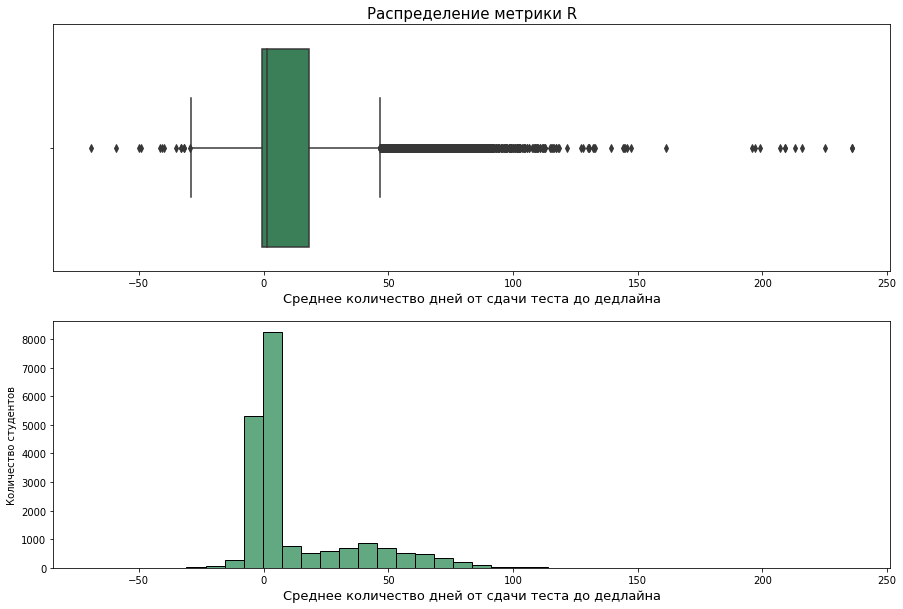

In [130]:
r_color = 'SeaGreen'

fig, axs = plt.subplots(2, 1, figsize=(15, 10))

sns.boxplot(data=RFM, x='recency', color=r_color, ax=axs[0])
axs[0].set_title("Распределение метрики R", fontsize=15)
axs[0].set_xlabel('Среднее количество дней от сдачи теста до дедлайна', fontsize=13)

sns.histplot(data=RFM, x='recency', color=r_color, bins=40,ax=axs[1])
plt.ylabel("Количество студентов")
axs[1].set_xlabel('Среднее количество дней от сдачи теста до дедлайна', fontsize=13)

plt.show()

Исходя из описательной статистики, разобъём метрику на диапазоны:
- [-69 до 0) - в этот диапазон входят студенты, которые в среднем сдают тесты позднее дедлайна, назовём их "**Сдающие позднее дедлайна**"
- [0 до 1) - в этот диапазон входят студенты, которые в среднем сдают тесты в последний момент, назовём их "**Сдающие в последний момент**"
- [1 до 13) - в этот диапазон входят студенты, которые сдают в рамках дедлайнов, назовём их "**Сдающие в рамках дедлайна**"
- [13 до 237) - в этот диапазон входят студенты, которые в среднем сдают тесты задолго до дедлайна, назовём их "**Сдающие задолго до дедлайна**"

Запишем получившиеся значения в столбец **R**

In [131]:
R_bins = [-69, 0, 1, 13, 237]
R_labels = ['Сдающие позднее дедлайна', 'Сдающие в последний момент', 'Сдающие в рамках дедлайна', 'Сдающие задолго до дедлайна']
RFM['R'] = pd.cut(RFM['recency'], R_bins, right=False, labels= R_labels)

Посмотрим на распределение метрики **R**

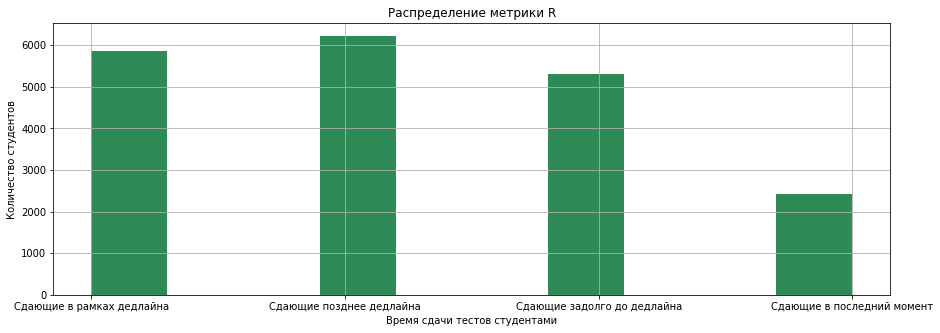

In [132]:
plt.figure(figsize=(15, 5))
RFM['R'].hist(color=r_color)
plt.title("Распределение метрики R")
plt.xlabel("Время сдачи тестов студентами")
plt.ylabel("Количество студентов")
plt.show()

### Frequency

Для создания кластеров метрики **frequency** посмотрим на её описательную статистику

In [133]:
RFM['frequency'].describe()

count    19949.000000
mean        70.022747
std         29.424851
min          0.000000
25%         50.000000
50%         75.000000
75%        100.000000
max        100.000000
Name: frequency, dtype: float64

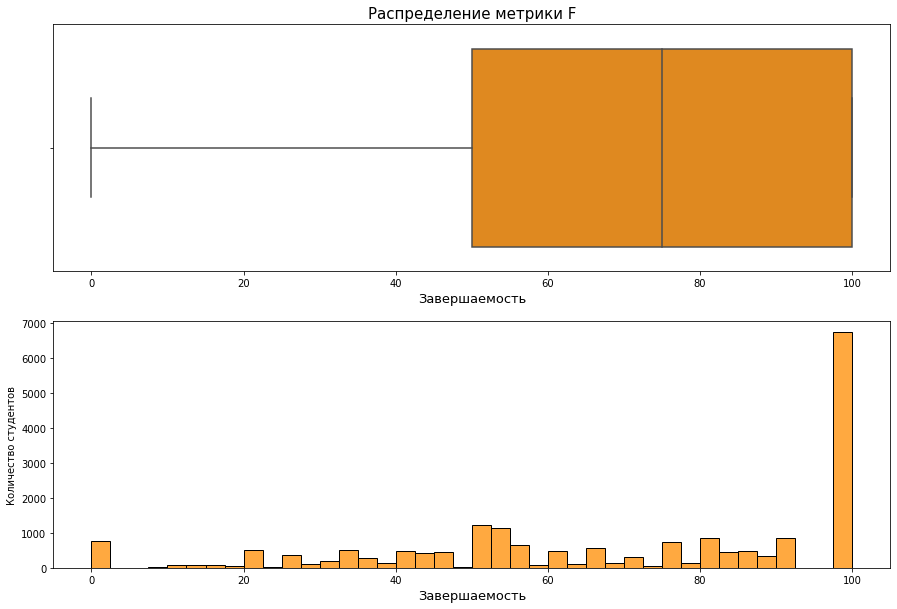

In [134]:
f_color = 'DarkOrange'

fig, axs = plt.subplots(2, 1, figsize=(15, 10))

sns.boxplot(data=RFM, x='frequency', color=f_color, ax=axs[0])
axs[0].set_title("Распределение метрики F", fontsize=15)
axs[0].set_xlabel('Завершаемость', fontsize=13)

sns.histplot(data=RFM, x='frequency', color=f_color, bins=40,ax=axs[1])
plt.ylabel("Количество студентов")
axs[1].set_xlabel('Завершаемость', fontsize=13)

plt.show()

Исходя из описательной статистики и здравого смысла, разобъём метрику на диапазоны:

- (0-25] %,
- (25-50] %, 
- (50-75] %,
- (75-100] %.

In [135]:
F_labels = ['0-25 %', '25-50 %', '50-75 %', '75-100 %'] 
RFM['F'] = pd.cut(RFM['frequency'], 4, right=False, labels= F_labels)

Посмотрим на распределение метрики **F**

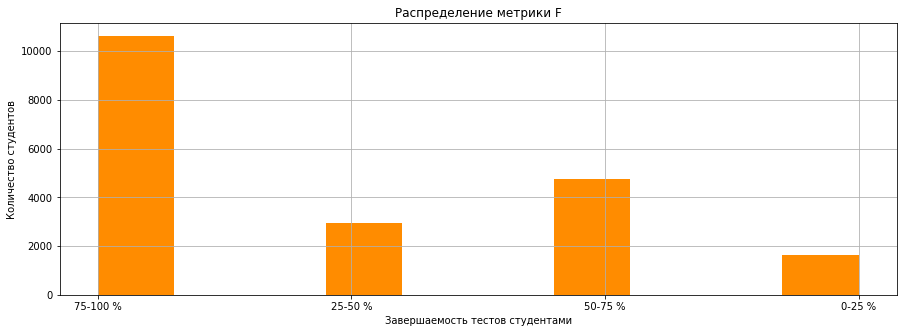

In [136]:
plt.figure(figsize=(15, 5))
RFM['F'].hist(color=f_color)
plt.title("Распределение метрики F")
plt.xlabel("Завершаемость тестов студентами")
plt.ylabel("Количество студентов")
plt.show()

### Monetary

Для создания кластеров метрики **monetary** посмотрим на её описательную статистику

In [137]:
RFM['monetary'].describe()

count    19949.000000
mean        74.622092
std         14.093980
min          0.000000
25%         66.875000
50%         77.181818
75%         85.000000
max        100.000000
Name: monetary, dtype: float64

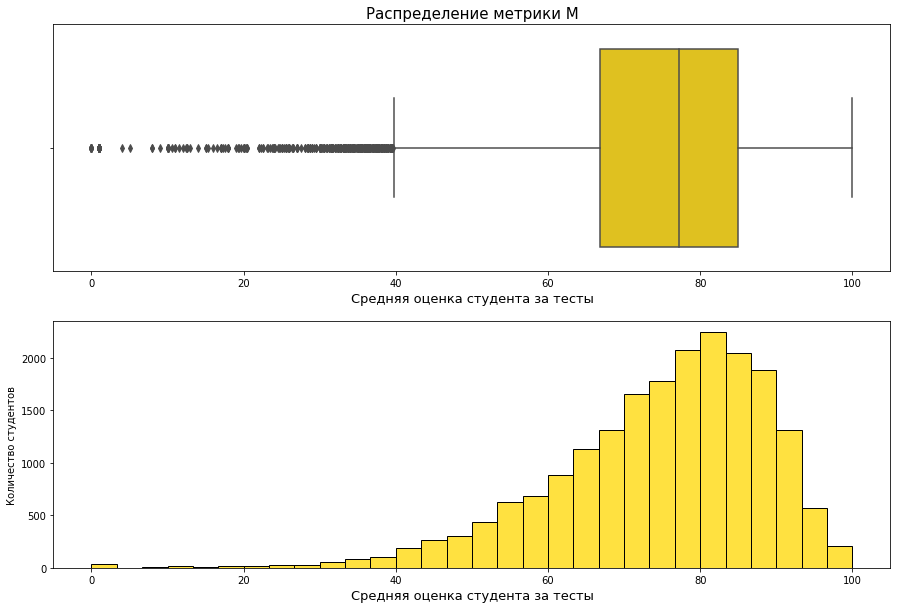

In [138]:
m_color = 'gold'

fig, axs = plt.subplots(2, 1, figsize=(15, 10))

sns.boxplot(data=RFM, x='monetary', color=m_color, ax=axs[0])
axs[0].set_title("Распределение метрики M", fontsize=15)
axs[0].set_xlabel('Средняя оценка студента за тесты', fontsize=13)

sns.histplot(data=RFM, x='monetary', color=m_color, bins=30,ax=axs[1])
axs[1].set_xlabel('Средняя оценка студента за тесты', fontsize=13)
plt.ylabel("Количество студентов")

plt.show()

Исходя из условий задания, нам известно, что оценки ниже **40** являются неуспешными. Соответственно, разобьём метрику на диапазоны:

- [0-40) баллов - Неуд. (Неудовлетворительно)
- [40-60) баллов - Уд. (Удовлетворительно)
- [60-80) баллов - Хорошо
- [80-101) баллов - Отлично

In [139]:
M_bins = [0, 40, 60, 80, 101]
M_labels = ['Неуд.', 'Удовл.', 'Хорошо', 'Отлично']
RFM['M'] = pd.cut(RFM['monetary'], M_bins, right=False, labels= M_labels)

Посмотрим на распределение метрики **M**

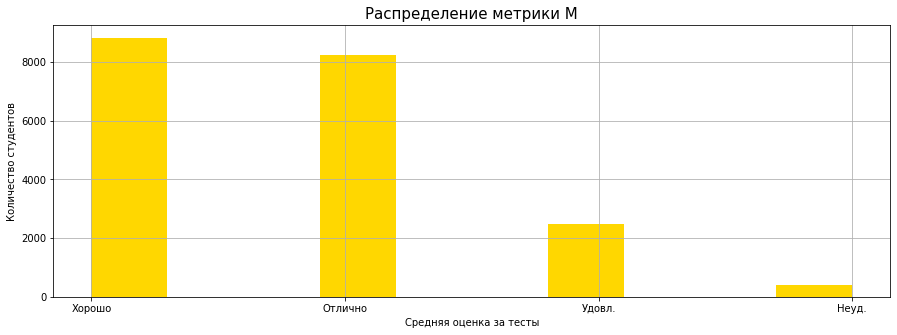

In [140]:
plt.figure(figsize=(15, 5))
RFM['M'].hist(color=m_color)
plt.title("Распределение метрики M", fontsize=15)
plt.xlabel("Средняя оценка за тесты")
plt.ylabel("Количество студентов")
plt.show()

### Визуализция сегментов студентов

Визуализируем данные, чтобы посмотреть на распределение метрик **RFM** и получить лучшее представление о студентах.

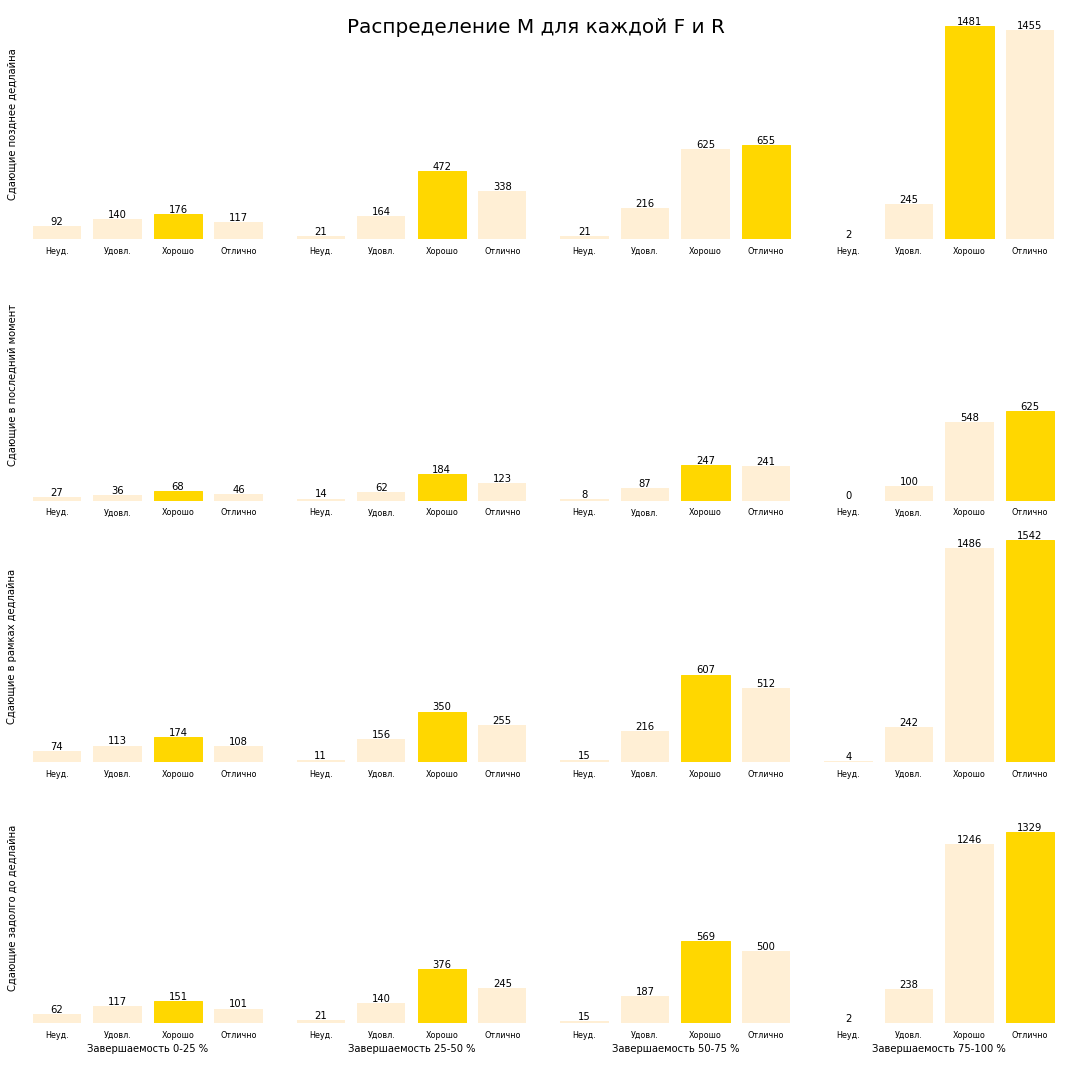

In [141]:
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(15, 15))

r_range = R_labels
f_range = F_labels
for r in range(len(r_range)):
    for f in range(len(f_range)):
        y = RFM[(RFM['R'] == R_labels[r]) & (RFM['F'] == F_labels[f])]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r, f]
        bars = ax.bar(x, y, color='PapayaWhip')
        if r == 3:
            ax.set_xlabel('Завершаемость {}\n'.format(f_range[f]), va='top')  
        if f == 0:
            ax.set_ylabel(r_range[r])
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color(m_color)
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='black')
fig.suptitle('Распределение M для каждой F и R',
             fontsize=20)
plt.tight_layout()
plt.show()

Исходя из данной визуализации видно: чем больше завершаемость курсов у студентов, тем выше оценки они получают. Срок сдачи тестов не сильно влияет на оценки, поэтому для построения RFM-кластеров будем акцентировать внимание на метриках **F** и **M**

Добавим в датафрейм **RFM** столбец с оценкой RFM-кластеров **RFM_score**.

Для каждой метрики создадим словари, в которых в качестве ключа будут названия кластеров, а в качестве значений соответствующая оценка от 2 до 5.

In [142]:
f_dict = {label: str(score) for score, label in enumerate(F_labels, start=2)}
m_dict = {label: str(score) for score, label in enumerate(M_labels, start=2)}

Создадим столбец **score**, в который запишем оценки каждого кластера, посмотрим на уникальные значения этого столбца

In [143]:
RFM['RFM_score'] = RFM['F'].apply(lambda x: f_dict[x]).astype(str)\
                   + RFM['M'].apply(lambda x: m_dict[x]).astype(str)
RFM['RFM_score'].unique()

array(['54', '55', '35', '44', '45', '34', '23', '53', '43', '22', '25',
       '24', '33', '42', '32', '52'], dtype=object)

Создадим кластеры студентов:

In [144]:
segt_map = {
    r'55': 'Лучшие студенты',
    r'54': 'Твёрдые хорошисты',
    r'4[45]': 'Хорошисты и отличники, сдающие 50-75% тестов',
    r'3[45]': 'Хорошисты и отличники, сдающие 25-50% тестов',
    r'2[45]': 'Хорошисты и отличники, сдающие менее 25% тестов',
    r'[45]3': 'Троечники, сдающие 50-100% тестов',
    r'[23]3': 'Возможно отменят регистрацию',
    r'[2-5]2': 'Под угрозой отчисления'
}

RFM['Segment'] = RFM['RFM_score'].replace(segt_map, regex=True)

Посмотрим на распределение сегментов.

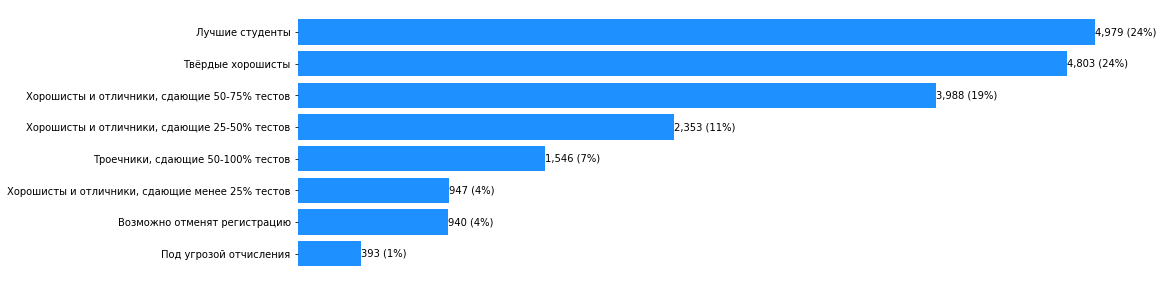

In [145]:
segments_counts = RFM['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(15, 5))

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='DodgerBlue')
ax.set_frame_on(False)
ax.tick_params(bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)
for i, bar in enumerate(bars):
        value = bar.get_width()
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left')
plt.show()

### Вывод:

- 67% студентов сдают большую часть тестов на оценки хорошо и отлично
- Всего 5% студентов не успевают/не усваивают материал
- Всего 1% студентов под угрозой отчисления

## Выводы по проекту:

- **Ответы на поставленные вопросы**:
    1. Количество студентов успешно сдавших только один курс: 
        * 2626 студентов сдали как минимум заключительный экзамен
        * 1029 студентов успешно сдали все необходимые тесты в рамках курса
    2.  Самые сложные и самые простые экзамены и курсы:
        * Самый сложный курс 2014B_CCC
        * Самый простой курс 2014J_FFF
        * Самый сложный экзамен - 2013B_DDD
        * Самый простой экзамен - 2014B_DDD
    3. Средние сроки сдачи экзаменов: 
        * CCC - 244 дня с начала семестра
        * DDD - 237 дней с начала семестра 
    4.  Самые популярные предметы (ТОП-3)
        * Топ 3 предмета:
            - по количеству регистраций: BBB, FFF, DDD;
            - по оттоку: FFF, BBB, DDD;
            - по успешности: GGG, AAA, EEE;
            - по неуспешности: CCC, DDD, FFF;
        * Топ 3 курса:
            - по количеству регистраций: 2014J_CCC, 2014J_FFF, 2014J_BBB;	
            - по оттоку: 2014J_CCC, 2014B_CCC, 2014J_FFF;	   
            - по успешности: 2013J_GGG, 2014B_GGG, 2013J_AAA;
            - по неуспешности: 2014B_CCC, 2014J_CCC, 2014B_DDD.
    5. Семестр с самой низкой завершаемостью курсов - 2013B. Семестр с самыми долгими средними сроками сдачи курсов -  2014J
    6. 67% студентов сдают большую часть тестов на оценки хорошо и отлично. Всего 5% студентов не успевают/не усваивают материал. Всего 1% студентов под угрозой отчисления

- **Для улучшения учебного процесса возможно следует выяснить**:

    - По какой причине студенты не сдают экзамены по следующему списку курсов: 2013J_AAA, 2014J_AAA, 2013B_BBB, 2013J_BBB, 2014B_BBB, 2014J_BBB, 2014B_CCC, 2014J_CCC, 2013J_EEE, 2014B_EEE, 2014J_EEE, 2013B_FFF, 2013J_FFF, 2014B_FFF, 2014J_FFF, 2013J_GGG, 2014B_GGG, 2014J_GGG?
    - Почему по курсам 2014B_ССС и 2014J_ССС студенты сдают только один экзамен, при положенных двух?
    - По какой причине для 11 курсов не установлены дедлайны сдачи экзаменов?
    - Почему студенты не сдают тесты на проверку преподавателям?
    - По какой причине студенту (id 501208) перезачли несданный тест TMA по курсу 2013J_BBB?
    - Почему в датах сдачи тестов присутствуют даты меньше -1, которые не являются перезачётами?
    - По какой причине в данных остутствуют 45 дат регистрации студентов?

- Возможно требуется усовершенствовать курс 2014B_CCC, в связи с очень низкой завершаемостью и курсы 2014B_CCC, 2014J_CCC, 2014B_DDD в связи с очень большим количеством отмен регистрации по отношению к количеству регистраций